# Community Water System Prediction Model

The [Division of Drinking Water](https://www.waterboards.ca.gov/drinking_water/programs/) (DDW) at the [California State Water Resources Control Board](https://www.waterboards.ca.gov/) regulates 2800 Community Water Systems (CWS) throughout the state. Some of these CWS risk running out of water during the dry summer season. This code creates a machine learning model that predicts which CWS face the highest risk of running out of water. The model is intended to run in production on a monthly basis, producing predictions for at-risk CWS within the subsequent ninety days. 

#### Resources
* A [searchable website](https://sdwis.waterboards.ca.gov/PDWW/) of community water systems
* A [searchable map](https://gispublic.waterboards.ca.gov/portal/apps/webappviewer/index.html?id=272351aa7db14435989647a86e6d3ad8) of community water systems

In [1]:
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
from datetime import datetime as dt_obj
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 2867)

### Read in the initial dataset

The initial data set provided by the DDW include two csv files that contain data from 2020 and 2021: `DroughtWatchPrioritization_v4.csv` and 
`DroughtWatchPrioritization_v9_input_data_with_TNC.csv`.  The files provide a list of CWS, various parameters that describe the CWS, and the outcome of each CWS at the end of 2021 via the label `DroughtExperienced`. If `DroughtExperienced` equals 1, a CWS ran out of water; otherwise, the system was safe.

This is a map that visualizes the location of each CWSID.

In [2]:
BUCKET_NAME = 'aae-water-dev-us-west-2'

In [3]:
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
water_bucket = s3.Bucket(BUCKET_NAME)

In [4]:
files = []
for water_bucket_object in water_bucket.objects.all():
    files.append(water_bucket_object.key)

In [5]:
dfs = []
for file in files:
    response = s3_client.get_object(Bucket=BUCKET_NAME, Key=file)
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
    print(status, file)
    if status == 200:
        dfs.append(pd.read_csv(response.get("Body")))

200 202304_TNC monthly-flow estimation.csv
200 DroughtWatchPrioritization_v4.csv
200 DroughtWatchPrioritization_v9_input_data_with_TNC.csv
200 HUC_Code_Name_Crosswalk.csv
200 dsci_export_20180501_20230524.csv
200 monthly_net_purchaser_output.csv
200 pws_intertie_sources.csv
200 seasonal_gw_measurements_output.csv
200 seasonal_net_purchaser_output.csv


In [6]:
df1 = dfs[1]
df2 = dfs[2]

The keyword `PWPhysicalAddressLat` in one dataframe is the same as `Lat` in other other; same with longitude. Rename these keywords.

In [7]:
df2 = df2.rename(columns={"Lat": "PWPhysicalAddressLat", "Long": "PWPhysicalAddressLong"})

Why are there multiple CWS at the same location? Is this correct? (See table below)

In [8]:
df2[['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']][30:39]

ServiceConnections  Population  CDAG_rank  PWPhysicalAddressLat  \
30                1742        4943         -1             38.382864   
31                 520        1060       2322             38.480957   
32                 388         907       1805             38.413058   
33                 215         510       1757             38.544707   
34                 211        1184       1445             38.191586   
35                 337         838       1636             38.458547   
36                2743        8809         -1             38.382864   
37                  82         200       1713             38.447565   
38                  55         188         -1             38.382864   

    PWPhysicalAddressLong  
30            -120.787745  
31            -120.847427  
32            -120.658861  
33            -120.741079  
34            -120.829103  
35            -120.541518  
36            -120.787745  
37            -120.537917  
38            -120.787745

What does a CDAG_rank of -1 mean? Is this the same as NaN? There are 666 CWS with a CDAG_rank of -1. (Showing only ten here).

In [9]:
df1[['ServiceConnections', 'Population', 'CWSID', 'CDAG_rank', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']].loc[df1['CDAG_rank'] == -1][10:20] 

ServiceConnections  Population      CWSID  CDAG_rank  \
29                2106        6170  CA0310002         -1   
30                1742        4943  CA0310003         -1   
36                2743        8809  CA0310012         -1   
38                  55         188  CA0310019         -1   
73               29610      104908  CA0410002         -1   
76                3551       10698  CA0410005         -1   
77                6909       22780  CA0410006         -1   
78                2369        4600  CA0410007         -1   
79                3077       10154  CA0410008         -1   
81                3198       10513  CA0410011         -1   

    PWPhysicalAddressLat  PWPhysicalAddressLong  
29             38.382864            -120.787745  
30             38.382864            -120.787745  
36             38.382864            -120.787745  
38             38.382864            -120.787745  
73             39.719981            -121.808483  
76             39.511060            -121.554885  
77             39.510752            -121.519610  
78             39.768527            -121.599204  
79             39.532157            -121.574237  
81             39.819135            -121.590983

Why are there far more active groundwater sources for this CWSID, yet CA0110001 is identified as primarily a surfacewater source (see [here](https://sdwis.waterboards.ca.gov/PDWW/JSP/WaterSystemDetail.jsp?tinwsys_is_number=29&tinwsys_st_code=CA))?

Merge the two dataframes using these keys: `ServiceConnections`, `Population`, `CDAG_rank`, and `Lat`. The ideal solution is to merge on the unique identifier, `CWSID`. However, `CWSID` is not present in both files.

In [11]:
df_initial = df1.merge(df2, on=['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat'])

Remove the '-' character from the HUC8 values to make them consistent with other datasets.

In [12]:
df_initial['HUC8'] = df_initial['HUC8'].str.replace("-", "").astype(int)

In [13]:
print("In 2021, ",df_initial[df_initial['DroughtExperienced_y'] == 1]['Population'].sum(),"people in California experienced some form of drought.")

In 2021,  1161365 people in California experienced some form of drought.


In [14]:
df_initial.shape

(2866, 78)

### Add Intertie Data

The intertie, or purchaser/seller, data (`pws_intertie_sources.csv`) contains data that described which public water systems purchased or sold water. These data are available for 752 public water systems. There are three types of public water systems: 
1. C - Community: Serves at least 15 service connections used by year-round residents or regularly serves 25 year-round residents.
2. NTNC - Non-Transient Non-Community: Serves at least the same 25 non-residential individuals during 6 months of the year.
3. NC - Transient Non-Community: Regularly serves at least 25 non-residential individuals (transient) during 60 or more days per year.

For the purposes of this study, we are only interested in community water systems. To whittle out the NTNC and NC water systems from the intertie data, we used [a list](https://sdwis.waterboards.ca.gov/PDWW/JSP/SearchDispatch?number=&name=&county=&WaterSystemType=All&WaterSystemStatus=A&SourceWaterType=All&action=Search+For+Water+Systems) of all the public water systems in the state mtaintained by The California Safe Drinking Water Information System. This list is also available on the [California Open Data Portal](https://data.ca.gov/dataset/drinking-water-public-water-system-information). After selecting only the community water systems and removing any NTNC or NC water systems, we are left with 671 community water systems or 23% of the total community water systems.

In order to use these data, we must impute the missing values. Let's see if it is reasonable to make the following assumptions:

* Assumption 1: Community water systems missing from this dataset do not have an intertie. **False**  
There are 103 community water systems with an Intertie value equal to one, but not included in the purchaser/seller dataset. Therefore, we cannot assume all community water systems in the purchaser/seller dataset have no interties. 

* Assumption 2: Community water systems missing from this dataset do not purchase or sell water. **False**  
Of these 103 community water systems, some have purchased water. We can take a look at one example: Community Water System [CA4810800](https://sdwis.waterboards.ca.gov/PDWW/JSP/WaterSystemDetail.jsp?tinwsys_is_number=4860&tinwsys_st_code=CA), California State Prison in Solano, has an intertie value of 1. It also purchased water from Community Water System CA4810008, the City of Vacaville. Nevertheless, we made Assumption 2 for the sake of experiment. Using both the Univariate Fisher / ANOVA F Score and Gini Impurity Importance, we found that none of the features are predictive.

For all these reasons, we do not use the intertie data in our analysis.

In [26]:
# Read in the intertie data
print("Add data for",files[6])
df_intertie = dfs[6]

Add data for pws_intertie_sources.csv


In [27]:
df_intertie.columns

Index(['pwsid', 'num_sources_purchased_from', 'num_sources_sold_to',
       'net_purchases', 'net_purchaser_flag'],
      dtype='object')

In [28]:
# Read in the list of all the public water systems
df_pws_calopendata = pd.read_csv('https://data.ca.gov/dataset/d6d3beac-6735-4127-9324-4e70f61698d9/resource/9dca2f92-4630-4bee-a9f9-69d2085b57e3/download/drinking-water-watch-public-water-system-facilities.txt', 
                                on_bad_lines='skip', delimiter='\t', header=None)

In [376]:
# Select rows that describe the public water system id and type (C, NTNC, or NC).
df_pws = df_pws_calopendata[[3,7]].rename(columns={7: "Type", 3: "pwsid"})

In [377]:
# Merge the list of all public water systems with the intertie data
df_intertie_and_pws = df_intertie.merge(df_pws, on='pwsid', how='left')

In [380]:
# Select only community water systems
df_intertie_and_cws = df_intertie_and_pws[df_intertie_and_pws['Type'] == 'C'].reset_index(drop=True).rename(columns={'pwsid': 'CWSID'})

In [379]:
# Print some statistics
print("The intertie data covers", df_intertie_and_pws['CWSID'].count(),"community water systems.")
print("The intertie data covers", df_intertie_and_pws['CWSID'].count()/df_initial['CWSID'].count()*100.,"% of the community water systems.")

The intertie data covers 671 community water systems.
The intertie data covers 23.41242149337055 % of the community water systems.


In [381]:
# Merge the community water system and intertie data with the initial data
df_initial_plus_intertie = df_initial.merge(df_intertie_and_cws, on='CWSID', how='left')

In [382]:
# Select only data where there is an intertie (i.e. the value of Intertie_x is equal to 1)
df_test_assumptions = df_initial_plus_intertie[(df_initial_plus_intertie['Intertie_x'] == 1)].reset_index(drop=True)

In [383]:
# Select the community water systems for which there is no value for the number of monthly purchases
df_test_assumptions = df_test_assumptions[df_test_assumptions['num_purchases_monthly'].isnull()]

In [384]:
# Count the number of community water systems for which there is an intertie but no value for the number of monthly purchases
df_test_assumptions[['CWSID','Intertie_x','Score_SourceNumber_x','num_purchases_monthly','num_sales_monthly']].count()

CWSID                    103
Intertie_x               103
Score_SourceNumber_x     103
num_purchases_monthly      0
num_sales_monthly          0
dtype: int64

In [390]:
# Look at one CWS in particular
df_test_assumptions[df_test_assumptions['CWSID'] == 'CA4810800'][['CWSID', 'RegulatingAgency', 'WaterSystemName', 'Intertie_x','Score_SourceNumber_x','num_purchases_monthly','num_sales_monthly']]

CWSID             RegulatingAgency                   WaterSystemName  \
565  CA4810800  DISTRICT 04 - SAN FRANCISCO  CALIFORNIA STATE PRISON - SOLANO   

     Intertie_x  Score_SourceNumber_x  num_purchases_monthly  \
565           1                   0.0                    NaN   

     num_sales_monthly  
565                NaN

In [469]:
# Make assumption 2

df_initial_plus_intertie['num_purchases_monthly'] = df_initial_plus_intertie['num_purchases_monthly'].fillna(0)
df_initial_plus_intertie['num_sales_monthly'] = df_initial_plus_intertie['num_sales_monthly'].fillna(0)

One particular attribute of the The California Safe Drinking Water Information System list assesses whether a water system is primarily a groundwater or surface water site. According to the [EPA's Detailed Facility Report Data Dictionary](https://echo.epa.gov/help/reports/dfr-data-dictionary), there are six different types of water sources:

* Surface Water - System has a surface source (e.g., river, reservoir, intake).  
* Ground Water - System has a groundwater source that is not under the direct influence of surface water (e.g., protected wells) and no surface water or groundwater under the influence of surface water sources.
* Ground Water Under Direct Influence of (UDI) Surface Water - System has a source that provides water under the direct influence of surface water (e.g., unprotected well or springs) and no surface water sources. 
* Purchased Surface Water - System purchases water that originates from a surface source (e.g., river, reservoir, intake.
* Purchased Groundwater - System purchases water that originates from groundwater source that is not under the direct influence of surface water (e.g., protected wells) and no surface water or groundwater under the influence of surface water sources.
* Purchased Groundwater UDI Surface Water - System purchases water that originates from a source that provides water under the direct influence of surface water(e.g., unprotected well or springs)and no surface water sources.

We incorporate this information into our initial data set by creating two new keys:

1. `Primary Source`, where `Groundwater` and `Groundwater Purchased` represents groundwater sources and equals 0, and the rest (`Surface Water`, `Groundwater UDI Surface Water`, `Surface Water Purchased`, `Groundwater UDI Surface Water Purchased`) represent surface water sources and equal 1.
2. `Purchased`, where `Groundwater Purchased`, `Surface Water Purchased`, and `Groundwater UDI Surface Water Purchased` represent purchased sources and equal 1, and the rest (`Groundwater`, `Surface Water`, `Groundwater UDI Surface Water`) represent non-purchased sources and equal 0.

When dividing the data this way, we are left with 2020 groundwater sources (`Primary Source == 0`) and 829 surface water sources. We are also left with 427 CWS that purchased water, and 2442 that did not purchase water.

The model does not perform any better when incorporating this type of purchasing data (as opposed to the intertie data), nor does performance improve by only including groundwater sources. Therefore, we do not need to use these keywords.

In [266]:
df_pws_calopendata[16].unique()

array(['Groundwater', 'Surface Water', 'Groundwater UDI Surface Water',
       'Groundwater Purchased', 'Surface Water Purchased', nan,
       'Groundwater UDI Surface Water Purchased'], dtype=object)

In [267]:
# Select rows that describe the source of water and create two new keys
df_pws = df_pws_calopendata[[16, 3]].rename(columns={16: "Primary Source", 3:'CWSID'})
df_pws['Purchased'] = df_pws['Primary Source'] 

In [268]:
# Create Primary Source
primary_source_dictionary = {'Groundwater': 0, 'Surface Water':1, 'Groundwater UDI Surface Water':1,
       'Groundwater Purchased':0, 'Surface Water Purchased':1,
       'Groundwater UDI Surface Water Purchased':1, np.nan: np.nan}
df_pws['Primary Source'] = df_pws['Primary Source'].apply(lambda x: primary_source_dictionary[x])

In [269]:
# Create Purhased
purchased_dictionary = {'Groundwater': 0, 'Surface Water':0, 'Groundwater UDI Surface Water':0,
       'Groundwater Purchased':1, 'Surface Water Purchased':1,
       'Groundwater UDI Surface Water Purchased':1, np.nan: np.nan}
df_pws['Purchased'] = df_pws['Purchased'].apply(lambda x: purchased_dictionary[x])

In [270]:
# Merge the list of all public water systems with the intertie data
df_initial_plus_pws = df_initial.merge(df_pws, on='CWSID', how='left').drop_duplicates().dropna()

In [271]:
df_initial_plus_pws.shape

(2849, 80)

In [272]:
df_initial_plus_pws['Purchased'].value_counts()

0.0    2422
1.0     427
Name: Purchased, dtype: int64

In [273]:
df_initial_plus_pws['Primary Source'].value_counts()

0.0    2020
1.0     829
Name: Primary Source, dtype: int64

### Add [Periodic Groundwater Level Measurements](https://data.cnra.ca.gov/dataset/periodic-groundwater-level-measurements) data

The Periodic Groundwater Level Measurement data, in the file `seasonal_gw_measurements_output.csv`, contains groundwater level measurements, taken periodically, for 2051 water systems. The groundwater data includes some public, but not community, water systems, e.g. CA0202501 (see a complete [list of all the community water systems in California](https://sdwis.waterboards.ca.gov/PDWW/JSP/SearchDispatch?number=&name=&county=&WaterSystemType=All&WaterSystemStatus=A&SourceWaterType=All&action=Search+For+Water+Systems) from the The Safe Drinking Water Information System). If we restict the data to include only community water systems that have data for both the wet and dry seasons of 2021, we have data for 1614 out of the 2866 groundwater sites, or 56% coverage. The outcome label experiences a similar decrease in coverage, from 156 to 83 positive examples.

This spase coverage means we need to impute almost half of the data, which will introduce a lot of noise into the dataset. In general, it is not adviseable to impute more than 10% of missing data. We can do a test by withholding some data, imputing the values for the witheld data, and then comparing the imputed values to the real values. We could possibly create categorical variables out of the numerical ones, applying a threshold at various points, and applying a neutral value to the remaining data.

Some notes about the groundwater metadata:
* Some CWSIDs do not have measurements taken during a dry or wet season, but have measurements taken during the opposite season. 
* If the value for the variable `gwe_std` is NaN, the value in the corresponding variable `gws_avg` represents one data point. 
* If the value for `CWSID` is NaN, there was some missing data in the mapping between basin and CWSID.
* Definitions for the feature named `season`: `2021_wet` corresponds to the time frame between 2020-10-01 and 2021-04-01. Therefore, `2022_wet` corresponds to the time frame between 2021-10-01 and 2022-04-01 and `2023_wet` corresponds to the time frame between 2022-10-01 and 2023-04-01.

In [17]:
print("Add data for",files[7])
df_groundwater = dfs[7]

Add data for seasonal_gw_measurements_output.csv


In [18]:
# Drop the columns basin_code and gwe_std, and rename PWSID to CWSID
df_groundwater = df_groundwater.drop(columns=['basin_code', 'gwe_std'])
df_groundwater = df_groundwater.rename(columns={"PWSID": "CWSID"})

In [19]:
# Drop all the values for which the CWSID is NaN
df_groundwater = df_groundwater[df_groundwater['CWSID'].notna()]

In [20]:
print("Number of CWSIDs that are not NaN:", df_groundwater['CWSID'].nunique())
print("Total number of possible CWSIDs:", df_initial['CWSID'].nunique())
print("Percentage of represented CWSIDs:", df_groundwater['CWSID'].nunique()/df_initial['CWSID'].nunique())

Number of CWSIDs that are not NaN: 2051
Total number of possible CWSIDs: 2866
Percentage of represented CWSIDs: 0.7156315422191207


In [21]:
# Drop all the values for which the average groundwater is NaN
df_groundwater = df_groundwater[df_groundwater['gwe_avg'].notna()]

In [22]:
# Choose all the rows that have values for the 2022 wet and dry season
df_groundwater = df_groundwater.loc[df_groundwater['season'].isin(['2021_wet', '2021_dry'])].reset_index(drop=True)

In [23]:
# Choose all CWSIDs that have values for both 2021_wet and 2021_dry
df_groundwater = df_groundwater[df_groundwater['CWSID'].duplicated()].reset_index(drop=True)

In [480]:
df_initial_plus_groundwater = df_initial_plus_intertie.merge(df_groundwater, on='CWSID', how='left')

In [481]:
df_initial_plus_groundwater = df_initial_plus_groundwater[df_initial_plus_groundwater['gwe_avg'].notna()].reset_index(drop=True)

In [26]:
print("Number of PWSIDs that are not NaN:", df_groundwater['CWSID'].nunique())
print("Number of non-NaN PWSIDs that are CWSIDs:", df_initial_plus_groundwater['CWSID'].nunique())
print("Total number of possible CWSIDs:", df_initial['CWSID'].nunique())
print("Percentage of represented CWSIDs:", df_initial_plus_groundwater['CWSID'].nunique()/df_initial['CWSID'].nunique())

Number of PWSIDs that are not NaN: 1847
Number of non-NaN PWSIDs that are CWSIDs: 1614
Total number of possible CWSIDs: 2866
Percentage of represented CWSIDs: 0.5631542219120725


### Add [California Natural Flows Data](https://rivers.codefornature.org)

The California Natural Flows Database (NFD) contains predicted natural stream flows for every stream in California at a monthly cadence from 1950 to 2022. The Nature Conservancy and the USGS used a three different random forest algorithms to model the flow rate in three different regions:
* Interior Mountains (including the Sierra Nevada and Klamath mountains)
* North Coastal Mountains (including the mountains in the north western portion of the state)
* Xeric (including the Central Valley, Central and South Coast, and desert portions of the state)

The process is described in [Zimmerman et al. 2017](https://doi.org/10.1111/fwb.13058). They acknowledge inflated values during the dry season, saying: "While the frequency of monthly flow alteration tended to be low, the degree of alteration was substantial. ... Inflation of monthly flows was most pronounced in the dry summer months, when flows in California streams are typically at their lowest level."

It may be useful to use actual measurements, rather than predicted values -- e.g. data from the [California Nevada River Forecast Center](https://www.cnrfc.noaa.gov/).


**Step 1: Obtain a complete list of HUC8 codes in California.** The California Department of Water Resources put a [simplifed mapping HUC8 codes](https://data.ca.gov/dataset/huc8-ca-simplified) within the state of California on the California Open Data Portal. Since HUC8 codes follow watershed boundaries, some span multiple states. This simplified mapping is clipped to the political boundary using ArcGIS.

**Step 2: Obtain flow data per HUC8 code per unit time.** The data are provided in a field called `value`.  

Complete Step 1:

In [15]:
url_huc8 = 'https://gis.data.cnra.ca.gov/datasets/02ff4971b8084ca593309036fb72289c_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'

In [16]:
df_huc8 = pd.read_csv(url_huc8)

Complete Step 2:

In [17]:
df0 = dfs[0]

In [18]:
df0['Date'] = df0[['year', 'month']].astype(str).agg('-'.join, axis=1) 

In [19]:
df0 = df0.drop(columns=['comid', 'statistic', 'variable', 'month', 'year', 'pct_rank',
       'GNIS_NAME', 'FTYPE', 'FCODE', 'stream_ord', 'name', 'method'])

In [20]:
# Convert the keyword MapDate into a datetime object
df0['Date'] = pd.to_datetime(df0['Date'], format = '%Y-%m').reset_index(drop=True)

In [21]:
# Define the dry season 2021
start_dry_season = dt_obj.fromisoformat('2021-05-01')
end_dry_season = dt_obj.fromisoformat('2021-09-30')

# Define the wet season 2021
start_wet_season = dt_obj.fromisoformat('2021-10-01')
end_wet_season = dt_obj.fromisoformat('2022-04-01')

In [22]:
all_huc_ids = []
all_average_flows_dry_season = []
all_max_flows_dry_season = []
all_standard_deviation_flows_dry_season = []
all_delta_flows = []
for i in range(len(df_huc8['HUC8'])):  
    # Get an individual HUC8 region in California
    one_huc8_code = df_huc8['HUC8'][i]
    print('Calculating features for HUC8 region',one_huc8_code, df_huc8['Name'][i])
    df_one_huc = df0[df0['huc8'] == one_huc8_code]

    # Identify the dry season
    mask_dry = (df_one_huc['Date'] > start_dry_season) & (df_one_huc['Date'] <= end_dry_season)
    df_dry = df_one_huc[mask_dry]
    
    # Calculate the maximum, average, and standard deviation of the flow during the dry season
    max_flow_dry_season = np.nanmax(df_dry['value'])
    average_flow_dry_season = np.nanmean(df_dry['value'])
    standard_deviation_dry_season_flow = np.nanstd(df_dry['value'])
    
    # Identify the wet season
    mask_wet = (df_one_huc['Date'] > start_wet_season) & (df_one_huc['Date'] <= end_wet_season)
    df_wet = df_one_huc[mask_wet]
    
    # Calculate the average flow during the wet season
    average_flow_wet_season = np.nanmean(df_wet['value'])
    
    # Calculate the change in average flow between dry and wet seasons
    delta_flow = average_flow_dry_season - average_flow_wet_season
    
    # Save the data to a list
    all_huc_ids.append(one_huc8_code)
    all_max_flows_dry_season.append(max_flow_dry_season)
    all_average_flows_dry_season.append(average_flow_dry_season)
    all_standard_deviation_flows_dry_season.append(standard_deviation_dry_season_flow)
    all_delta_flows.append(delta_flow)

Calculating features for HUC8 region 18100204 Salton Sea
Calculating features for HUC8 region 18070303 San Luis Rey-Escondido
Calculating features for HUC8 region 18070304 San Diego
Calculating features for HUC8 region 18020162 Upper Putah
Calculating features for HUC8 region 18050001 Suisun Bay
Calculating features for HUC8 region 15030102 Piute Wash
Calculating features for HUC8 region 18100100 Southern Mojave
Calculating features for HUC8 region 18030003 Middle Kern-Upper Tehachapi-Grapevine
Calculating features for HUC8 region 18060003 Carrizo Plain
Calculating features for HUC8 region 18060007 Cuyama
Calculating features for HUC8 region 18070102 Santa Clara
Calculating features for HUC8 region 18090206 Antelope-Fremont Valleys
Calculating features for HUC8 region 18020002 Upper Pit
Calculating features for HUC8 region 18080002 Madeline Plains
Calculating features for HUC8 region 17100309 Applegate
Calculating features for HUC8 region 17100311 Illinois
Calculating features for HUC8

In [23]:
df_flow_data = pd.DataFrame({'HUC8': all_huc_ids, 
                   'Flow Dry Season Max': all_max_flows_dry_season,        
                   'Flow Dry Season Average': all_average_flows_dry_season,
                   'Flow Dry Season Standard Deviation': all_standard_deviation_flows_dry_season,
                   'Flow Dry Wet Delta': all_delta_flows})

In [24]:
df_initial_plus_flow = df_initial.merge(df_flow_data, on='HUC8', how='left')
#df_initial_plus_flow = df_initial_plus_groundwater.merge(df_flow_data, on='HUC8', how='left')

In [25]:
df_initial_plus_flow.shape

(2866, 82)

### Add [US Drought Monitor Data](https://droughtmonitor.unl.edu/)

The US Drought Monitor Database creates a weighted blend of multiple observational data (precipitation, streamflow, reservoir levels, temperature and evaporative demand, soil moisture, vegetation health) into an index called the Drought Severity and Coverage Index (DSCI). These data are available on a weekly cadence from 2000 until the present day.

**Step 1: Obtain a complete list of HUC8 codes in California.** The California Department of Water Resources put a [simplifed mapping HUC8 codes](https://data.ca.gov/dataset/huc8-ca-simplified) within the state of California on the California Open Data Portal. Since HUC8 codes follow watershed boundaries, some span multiple states. This simplified mapping is clipped to the political boundary using ArcGIS.

**Step 2: Obtain DSCI data per HUC8 code per unit time.** 
* The [US Drought Monitor Index](https://droughtmonitor.unl.edu/) provides several drought-related datasets. These data are available through a REST API. 
* Construct the URL for the REST API. The query terms are: 
  * `[area]` = `HUCStatistics`
  * `[statistics type]` = `GetDroughtSeverityStatisticsByAreaPercent` (Note: One could use `GetDSCI`, but this will not return HUC8 codes as a key)
  * `[aoi]` = Any given HUC8 code, e.g. 15040004
  * `[start date]` = 01/01/2021
  * `[end date]` = 01/01/2022
  * `[statistics type]` = 2. (Note: This is a different keyword from the first statistics type. A statistics type of 2 refers to categorical statistics).
* Here is an example URL: url_dsci = `https://usdmdataservices.unl.edu/api/HUCStatistics/GetDroughtSeverityStatisticsByAreaPercent?aoi=15040004&startdate=1/2/2021&enddate=12/27/2021&statisticsType=2`

**Step 3: Calculate the Drought Severity and Coverage Index (DSCI).** Compute a weighted sum of the categorical percent area as described [here](https://droughtmonitor.unl.edu/About/AbouttheData/DSCI.aspx): DSCI = 1(D0) + 2(D1) + 3(D2) + 4(D3) + 5(D4)

Step 1, add additional seasons:

In [26]:
# Define the dry seasons
dry_seasons_start = [dt_obj.fromisoformat('2021-05-01'), dt_obj.fromisoformat('2020-05-01'), dt_obj.fromisoformat('2019-05-01')]
dry_seasons_end = [dt_obj.fromisoformat('2021-09-30'), dt_obj.fromisoformat('2020-09-30'), dt_obj.fromisoformat('2019-09-30')]

# Define the wet seasons
wet_seasons_start = [dt_obj.fromisoformat('2021-10-01'), dt_obj.fromisoformat('2020-10-01'), dt_obj.fromisoformat('2019-10-01')]
wet_seasons_end = [dt_obj.fromisoformat('2022-04-01'), dt_obj.fromisoformat('2021-04-01'), dt_obj.fromisoformat('2020-04-01')]

Complete Steps 2 and 3:

In [27]:
all_huc_ids = []
all_average_dscis_dry_season = []
all_max_dscis_dry_season = []
all_standard_deviation_dscis_dry_season = []
all_delta_dscis = []
years_average_dscis_dry_season = []
years_max_dscis_dry_season = []
years_standard_deviation_dscis_dry_season = []
years_delta_dscis = []
for i in range(len(df_huc8['HUC8'])):
    # Get an individual HUC8 region in California
    one_huc8_code = df_huc8['HUC8'][i]
    print('Fetching data for HUC8 region',one_huc8_code, df_huc8['Name'][i])
    url_dsci = 'https://usdmdataservices.unl.edu/api/HUCStatistics/GetDroughtSeverityStatisticsByAreaPercent?aoi='+str(one_huc8_code)+'&startdate=1/1/2019&enddate=12/31/2021&statisticsType=2'
    df_one_huc = pd.read_json(url_dsci)
    
    # Convert the keyword MapDate into a datetime object
    df_one_huc['MapDate'] = pd.to_datetime(df_one_huc['MapDate'], format = '%Y%m%d').reset_index(drop=True)
    
    # Save the data to a list
    all_huc_ids.append(one_huc8_code)

    for j in range(len(dry_seasons_start)):
        # Identify one dry season
        mask_dry = (df_one_huc['MapDate'] > dry_seasons_start[j]) & (df_one_huc['MapDate'] <= dry_seasons_end[j])
        df_dry = df_one_huc[mask_dry]

        # Calculate the maximum, average, and standard deviation of the DSCI during the dry season
        max_dsci_dry_season = np.nanmax(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)
        average_dsci_dry_season = np.nanmean(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)
        standard_deviation_dry_season_dsci = np.nanstd(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)

        # Identify one wet season
        mask_wet = (df_one_huc['MapDate'] > wet_seasons_start[j]) & (df_one_huc['MapDate'] <= wet_seasons_end[j])
        df_wet = df_one_huc[mask_wet]

        # Calculate the average DSCI during the wet season
        average_dsci_wet_season = np.nanmean(1*df_wet.D0 + 2*df_wet.D1 + 3*df_wet.D2 + 4*df_wet.D3 + 5*df_wet.D4)

        # Calculate the change in average DSCI between dry and wet seasons
        delta_dsci = average_dsci_dry_season - average_dsci_wet_season
    
        # Concatenate each feature by years
        years_max_dscis_dry_season.append(max_dsci_dry_season)
        years_average_dscis_dry_season.append(average_dsci_dry_season)
        years_standard_deviation_dscis_dry_season.append(standard_deviation_dry_season_dsci)
        years_delta_dscis.append(delta_dsci)
    
    # Save the data to a list
    all_max_dscis_dry_season.append(years_max_dscis_dry_season)
    all_average_dscis_dry_season.append(years_average_dscis_dry_season)
    all_standard_deviation_dscis_dry_season.append(years_standard_deviation_dscis_dry_season)
    all_delta_dscis.append(years_delta_dscis)
    
    years_average_dscis_dry_season = []
    years_max_dscis_dry_season = []
    years_standard_deviation_dscis_dry_season = []
    years_delta_dscis = []

Fetching data for HUC8 region 18100204 Salton Sea
Fetching data for HUC8 region 18070303 San Luis Rey-Escondido
Fetching data for HUC8 region 18070304 San Diego
Fetching data for HUC8 region 18020162 Upper Putah
Fetching data for HUC8 region 18050001 Suisun Bay
Fetching data for HUC8 region 15030102 Piute Wash
Fetching data for HUC8 region 18100100 Southern Mojave
Fetching data for HUC8 region 18030003 Middle Kern-Upper Tehachapi-Grapevine
Fetching data for HUC8 region 18060003 Carrizo Plain
Fetching data for HUC8 region 18060007 Cuyama
Fetching data for HUC8 region 18070102 Santa Clara
Fetching data for HUC8 region 18090206 Antelope-Fremont Valleys
Fetching data for HUC8 region 18020002 Upper Pit
Fetching data for HUC8 region 18080002 Madeline Plains
Fetching data for HUC8 region 17100309 Applegate
Fetching data for HUC8 region 17100311 Illinois
Fetching data for HUC8 region 18030009 Upper Dry
Fetching data for HUC8 region 18040001 Middle San Joaquin-Lower Chowchilla
Fetching data for

In [28]:
df_drought_data = pd.DataFrame({
                   'HUC8': all_huc_ids, 
                   'DSCI 2021 Dry Season Max': [item[0] for item in all_max_dscis_dry_season],        
                   'DSCI 2021 Dry Season Average': [item[0] for item in all_average_dscis_dry_season],
                   'DSCI 2021 Dry Season Standard Deviation': [item[0] for item in all_standard_deviation_dscis_dry_season],
                   'DSCI 2021 Dry Wet Delta': [item[0] for item in all_delta_dscis],
                   'DSCI 2020 Dry Season Max': [item[1] for item in all_max_dscis_dry_season],        
                   'DSCI 2020 Dry Season Average': [item[1] for item in all_average_dscis_dry_season],
                   'DSCI 2020 Dry Season Standard Deviation': [item[1] for item in all_standard_deviation_dscis_dry_season],
                   'DSCI 2020 Dry Wet Delta': [item[1] for item in all_delta_dscis],  
                   'DSCI 2019 Dry Season Max': [item[2] for item in all_max_dscis_dry_season],        
                   'DSCI 2019 Dry Season Average': [item[2] for item in all_average_dscis_dry_season],
                   'DSCI 2019 Dry Season Standard Deviation': [item[2] for item in all_standard_deviation_dscis_dry_season],
                   'DSCI 2019 Dry Wet Delta': [item[2] for item in all_delta_dscis],
})

In [29]:
df = df_initial_plus_flow.merge(df_drought_data, on='HUC8', how='left')

In [30]:
df['CWSID'].nunique()

2866

### Select and redefine keywords for the model

Rename columns so they make more sense.

In [31]:
df.columns = df.columns.str.removesuffix("_x")
df.columns = df.columns.str.removesuffix("_y")

In [32]:
# Drop duplicate columns
df = df.loc[:,~df.columns.duplicated()].copy()

Redefine the following keys: 
* `CentralValleyCounties`: No is set to zero and everything else is set to 1.
* `FracturedRock`: Set string '0-000' to 0 and set 'FR-999' to 1.
* `CurtailedWatershed`: Set string 'NotInCurtailedWatershed' to 0 and everything else to 1.

Create the following new keys:
* `HUC_Categories`: The keys `HUC8_CentralValley`, `HUC8_Coast`, and `HUC8_Other` contain values that include 8-digit HUC codes or strings. The string values are identical to the keyword names (i.e. 'HUC8_CentralValley', 'HUC8_Coast', and 'HUC8_Other'). Set these string values to 1, 2, and 3, respectively, and gather these into a separate keywords called 'HUC8_Categories'.

Skip the following keys:
* `Basin_Number_part1`, `Basin12`, `Basin34`, `Basin5`, `Basin6`, `Basin789`: Ignore these variables for now to avoid introducing noise into the data set (by one-hot-encoding six variables, all of which have many possible values).

In [33]:
# Redefine CentralValleyCounties
region_dictionary = {'No':0, 'BUTTE':1, 'COLUSA':1, 'FRESNO':1, 'GLENN':1, 'KERN':1, 'KINGS':1,
       'MADERA':1, 'MERCED':1, 'PLACER':1, 'SACRAMENTO':1, 'SAN JOAQUIN':1,
       'SHASTA':1, 'SOLANO':1, 'STANISLAUS':1, 'SUTTER':1, 'TEHAMA':1, 'TULARE':1,
       'YOLO':1, 'YUBA':1}
df['CentralValleyCounties'] = df['CentralValleyCounties'].apply(lambda x: region_dictionary[x])

In [34]:
# Redefine FracturedRock
fracturedrock_dictionary = {'0-000':0, 'FR-999':1}
df['FracturedRock'] = df['FracturedRock'].apply(lambda x: fracturedrock_dictionary[x])

In [35]:
# Redefine CurtailedWatershed
watershed_dictionary = {'NotInCurtailedWatershed':0, 'PartialSacSJ':1, 'PartialSJ':1,
       'SanJoaquinRiver':1, 'SacramentoRiver':1, 'SacSJ':1, 'RussianRiver':1,
       'PartialRus':1, 'PartialSac':1, 'ScottRiver':1, 'ShastaRiver':1,
       'PartialShasta':1}
df['CurtailedWatershed'] = df['CurtailedWatershed'].apply(lambda x: watershed_dictionary[x])

In [36]:
# Create HUC_Categories

df['HUC8_CentralValley'] = df['HUC8_CentralValley'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Coast'] = df['HUC8_Coast'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Other'] = df['HUC8_Other'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Other'] = df['HUC8_Other'].replace(to_replace='160*', value=0, regex=True)

df = df.replace(to_replace='HUC8_Coast', value=1)
df = df.replace(to_replace='HUC8_CentralValley', value=2)
df = df.replace(to_replace='HUC8_Other', value=3)

df['HUC_Categories'] = np.nan

df['HUC_Categories'] = df[['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other']].max(axis=1, numeric_only=True)

df = df.drop(columns=['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other'])

Select the keywords to use in the model:

In [37]:
keywords_to_use_in_the_model = [
 'DroughtExperienced',
 'SAFER_AccessibilityScore',
 'Curtailment',
 'CDAG_rank',
 'PWPhysicalAddressLong',
 'Population',
 'ServiceConnections',
 'PWPhysicalAddressLat',
 'ActiveSWSource',
 'DSCI 2021 Dry Season Standard Deviation',
 'DSCI 2019 Dry Wet Delta',
 'ActiveGWSource',
 'EAR2020DroughtRiskScore',
 'DSCI 2020 Dry Season Standard Deviation',
 'DSCI 2020 Dry Wet Delta',
 'DSCI 2021 Dry Wet Delta',
 'DSCI2WYAvg',
 'Score_SCV',
 'DSCI 2020 Dry Season Max',
 'Score_SourceNumber',
 'DSCI 2021 Dry Season Average',
 'Score_CriticallyOverdraftedGroundwaterBasin',
 'Flow Dry Season Standard Deviation',
 'Score_1813',
 'Flow Dry Wet Delta',
 'Score_SCM',
 'TNCFlow2WYAvg',
 'DSCI 2021 Dry Season Max',
 'Score_1814',
 'DSCI 2020 Dry Season Average',
 'Flow Dry Season Average',
 'Flow Dry Season Max',
 'Score_1812',
 'HUC4',
 'Score_1702',
 'FracturedRock',
 'Score_1815',
 'Score_1705',
 'Score_1706',
 'Intertie',
 'HUC_Categories',
 'CentralValleyCounties',
 'CurtailedWatershed',
 'DSCI 2019 Dry Season Average',
 'DSCI 2019 Dry Season Max',
 'DSCI 2019 Dry Season Standard Deviation',
#'gwe_avg', 'num_purchases_monthly', 'num_sales_monthly',
 'WaterOutageDroughtViolation',
 'BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',
 'Score_1704',
 'FundedProject'
]

In [38]:
df_all = df[keywords_to_use_in_the_model]

In [39]:
df = df_all.drop(columns = [
 'WaterOutageDroughtViolation',
 'BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',
 'Score_1704',
 'FundedProject'])

### Exploratory Data Analysis

* Plot the Univarite Fisher Score
* Make a catplot of the curtailment versus population
* Make a catplot curtailment versus service connections
* Make a kernel density estimate pairplot for some risk scores 

[Text(0.5, 0, 'Normalized Fisher Score')]

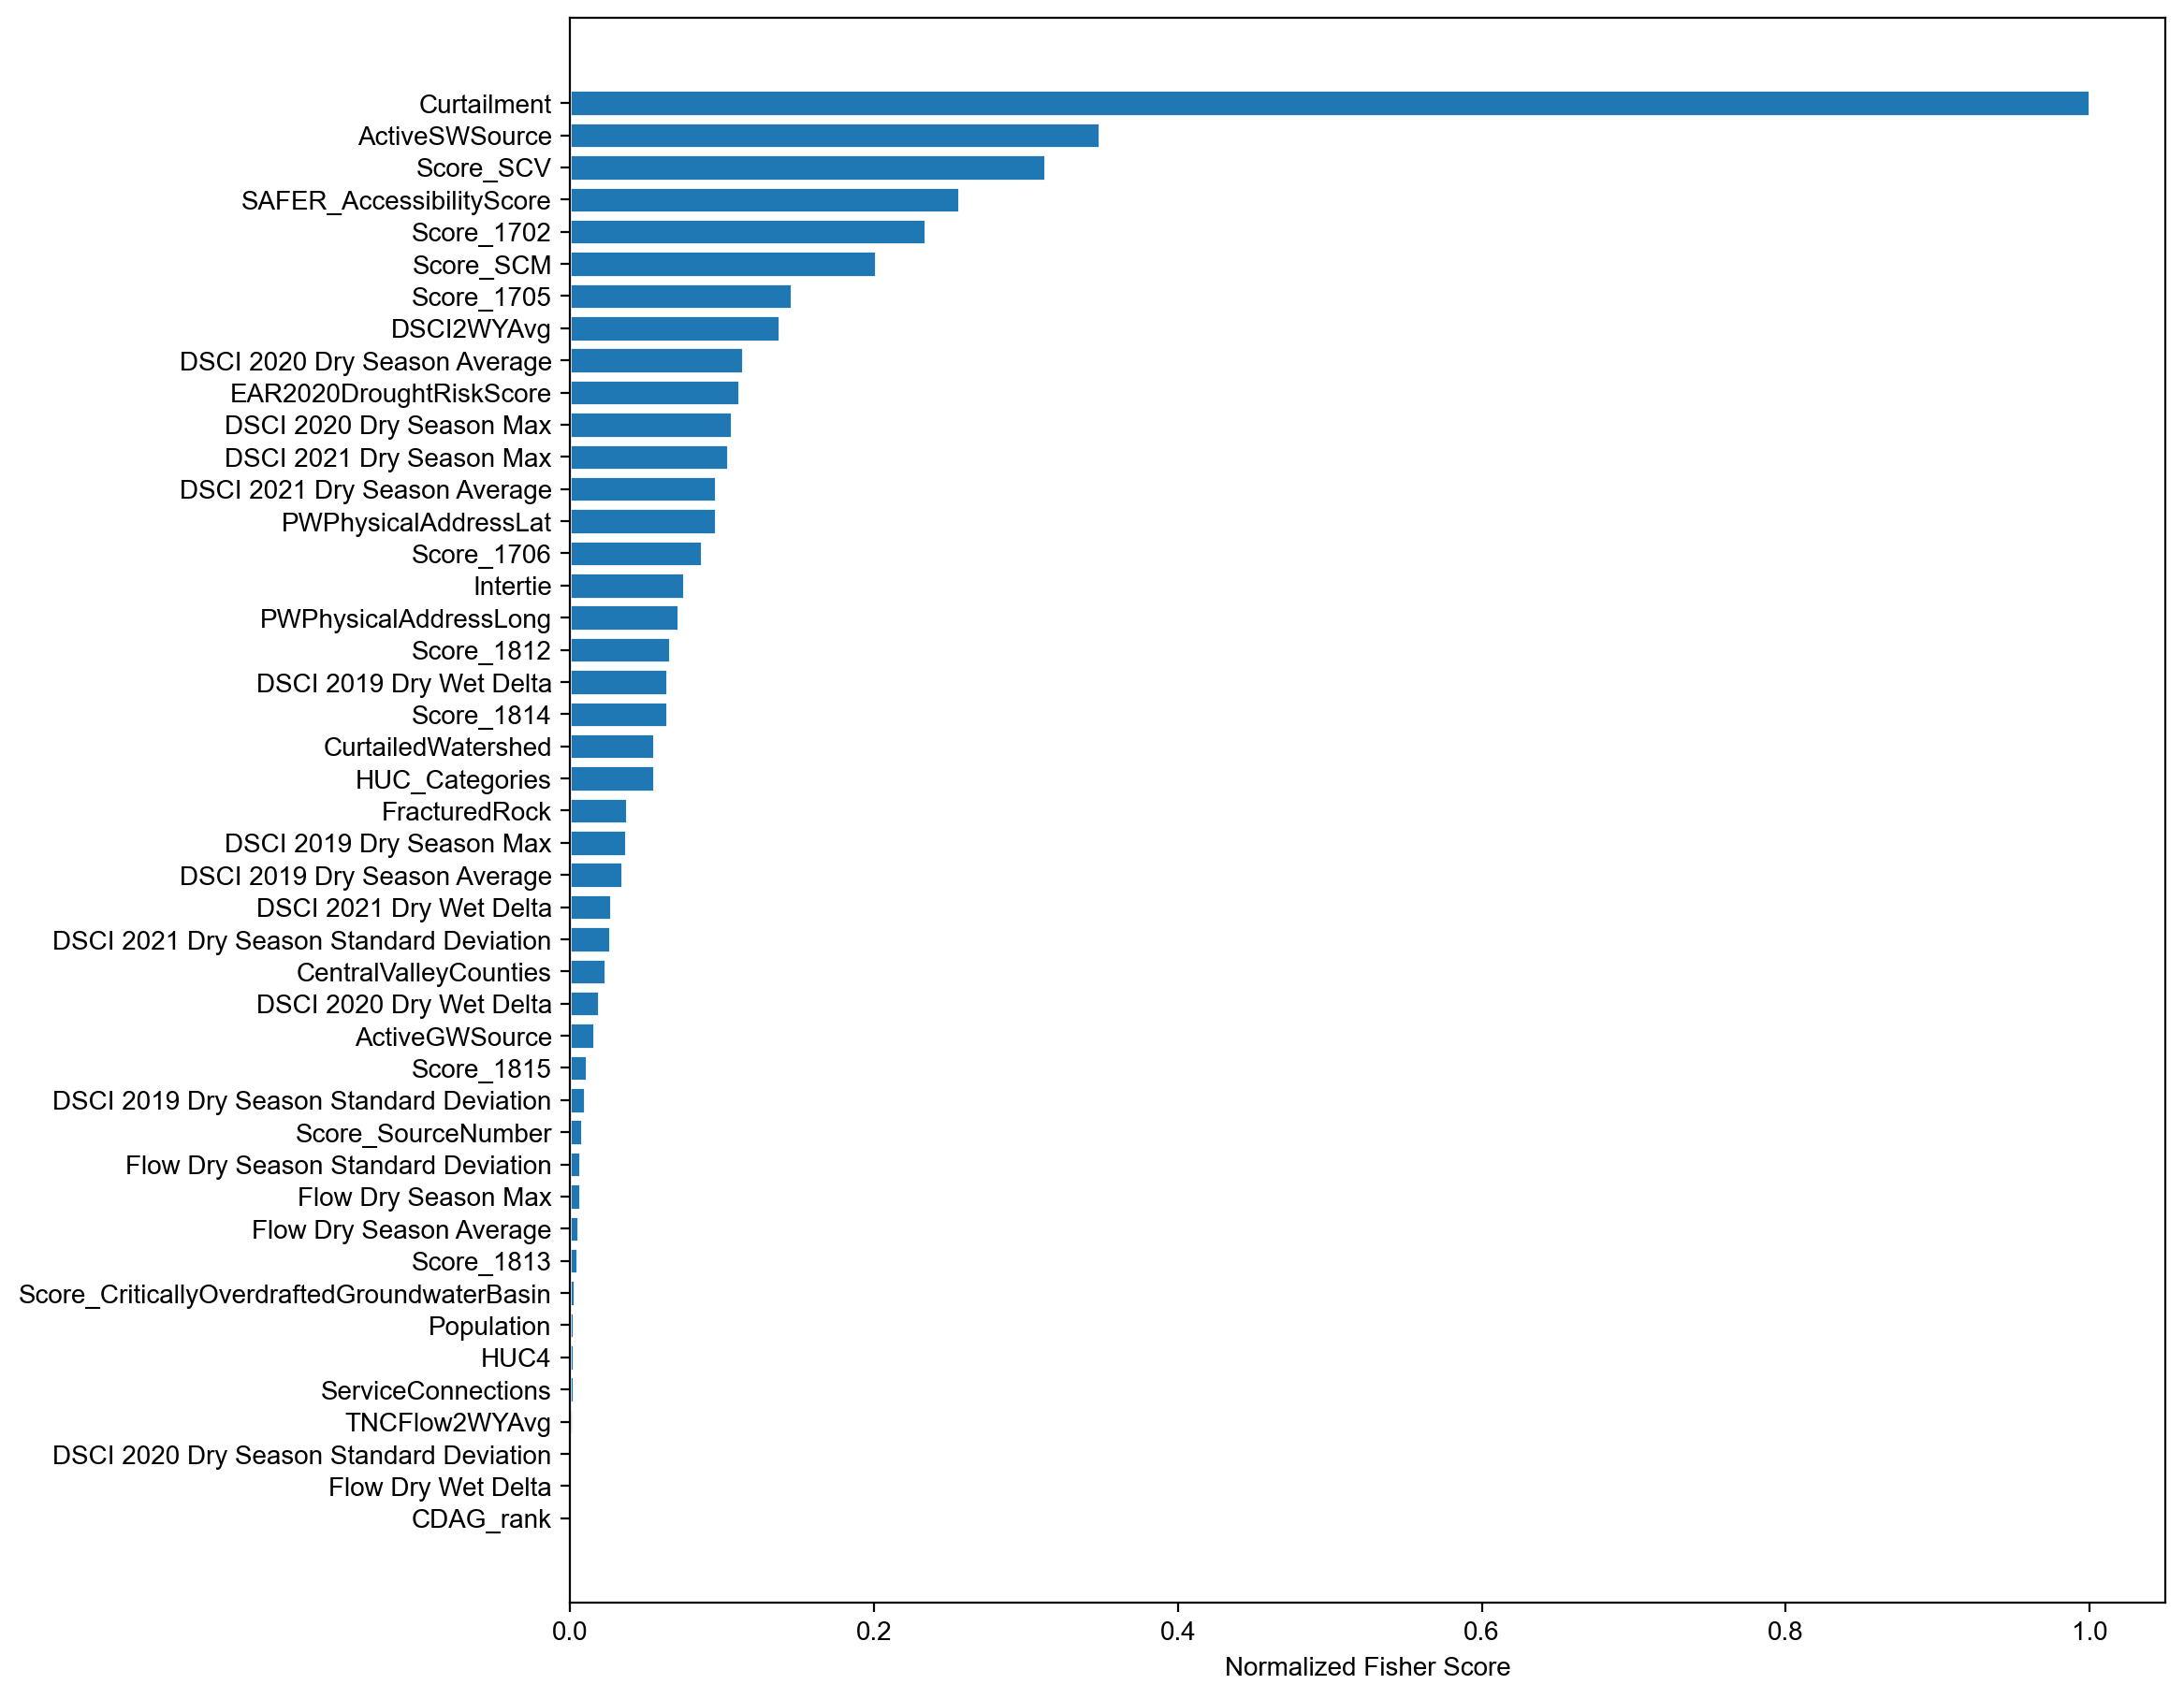

In [40]:
fig, ax = plt.subplots(figsize=(11,11))
sns.set_theme(style='whitegrid')

selector=SelectKBest(f_classif, k='all')
collist = df.columns.tolist()
selector.fit(df[collist[1:]],df['DroughtExperienced'])
scores_fisher = selector.scores_
scores_fisher[np.isnan(scores_fisher)] = 0.0

features = df[collist[1:]].columns.to_list()
order = np.argsort(scores_fisher)
ordered_features_fisher = [features[i] for i in order]
ordered_normalized_scores_fisher = sorted(scores_fisher/np.nanmax(scores_fisher))
ordered_scores_fisher = sorted(scores_fisher)

ax.barh(ordered_features_fisher, ordered_normalized_scores_fisher)
ax.set(xlabel = 'Normalized Fisher Score')
#fig.savefig('features.png', dpi=300, transparent=True, bbox_inches='tight')

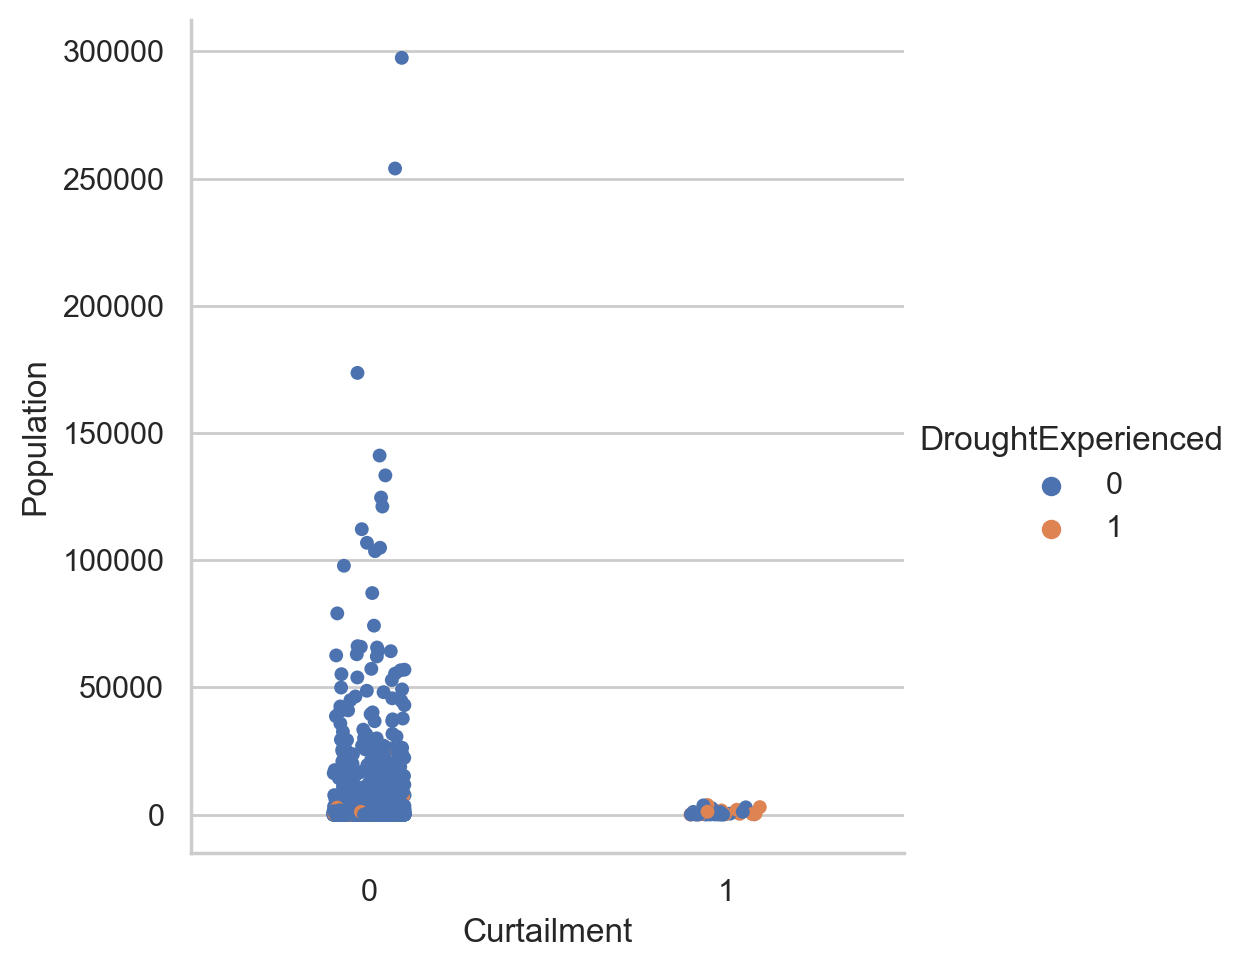

In [211]:
sns.set_theme(style='whitegrid')
fig = sns.catplot(data=df, x="Curtailment", y="Population", hue="DroughtExperienced")
#fig.savefig('curtailmentvpopulation.png', dpi=300, transparent=True, bbox_inches='tight')

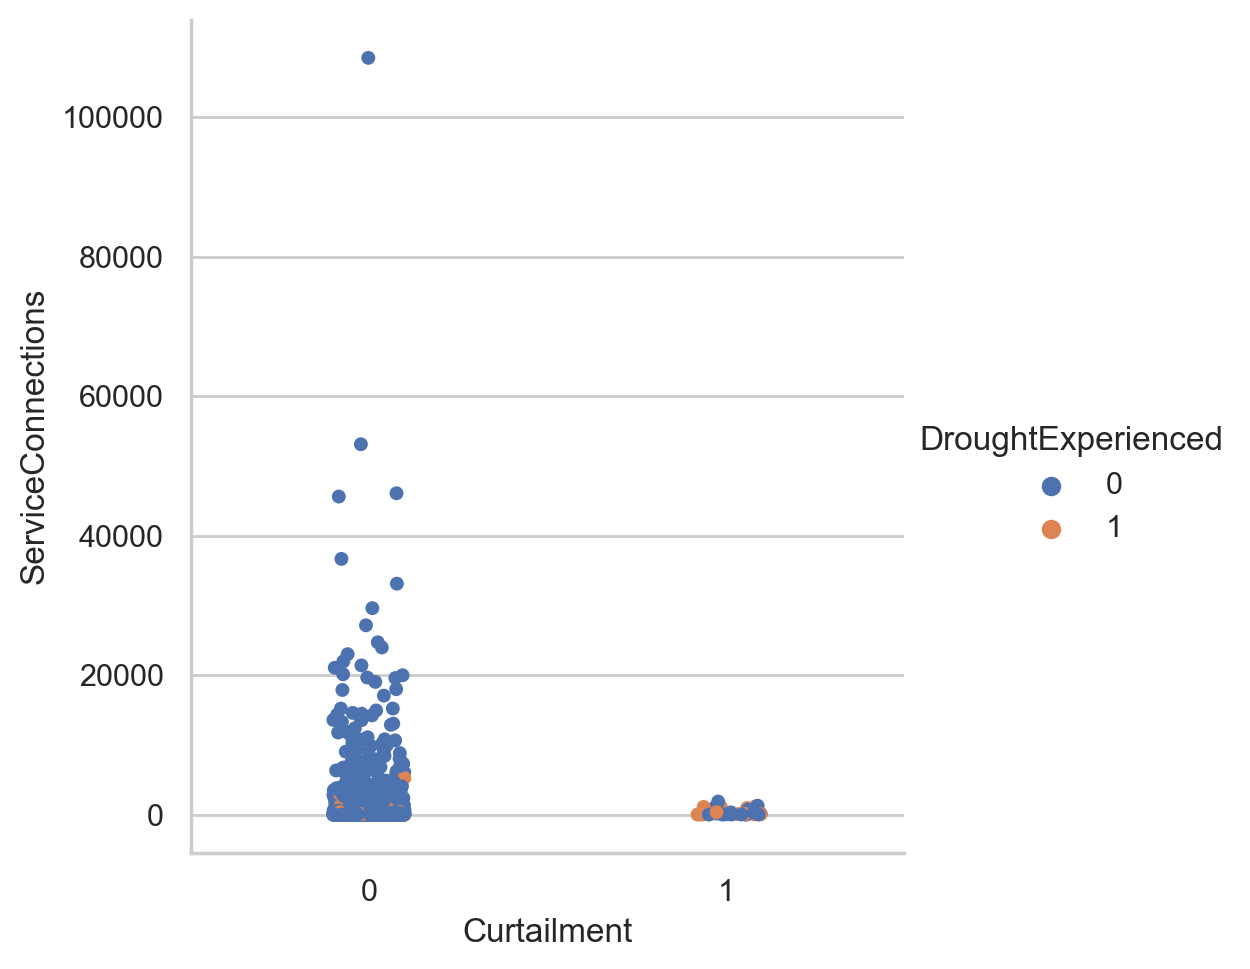

In [212]:
fig = sns.catplot(data=df, x="Curtailment", y="ServiceConnections", hue="DroughtExperienced")
#fig.savefig('curtailmentvserviceconnections.png', dpi=300, transparent=True, bbox_inches='tight')

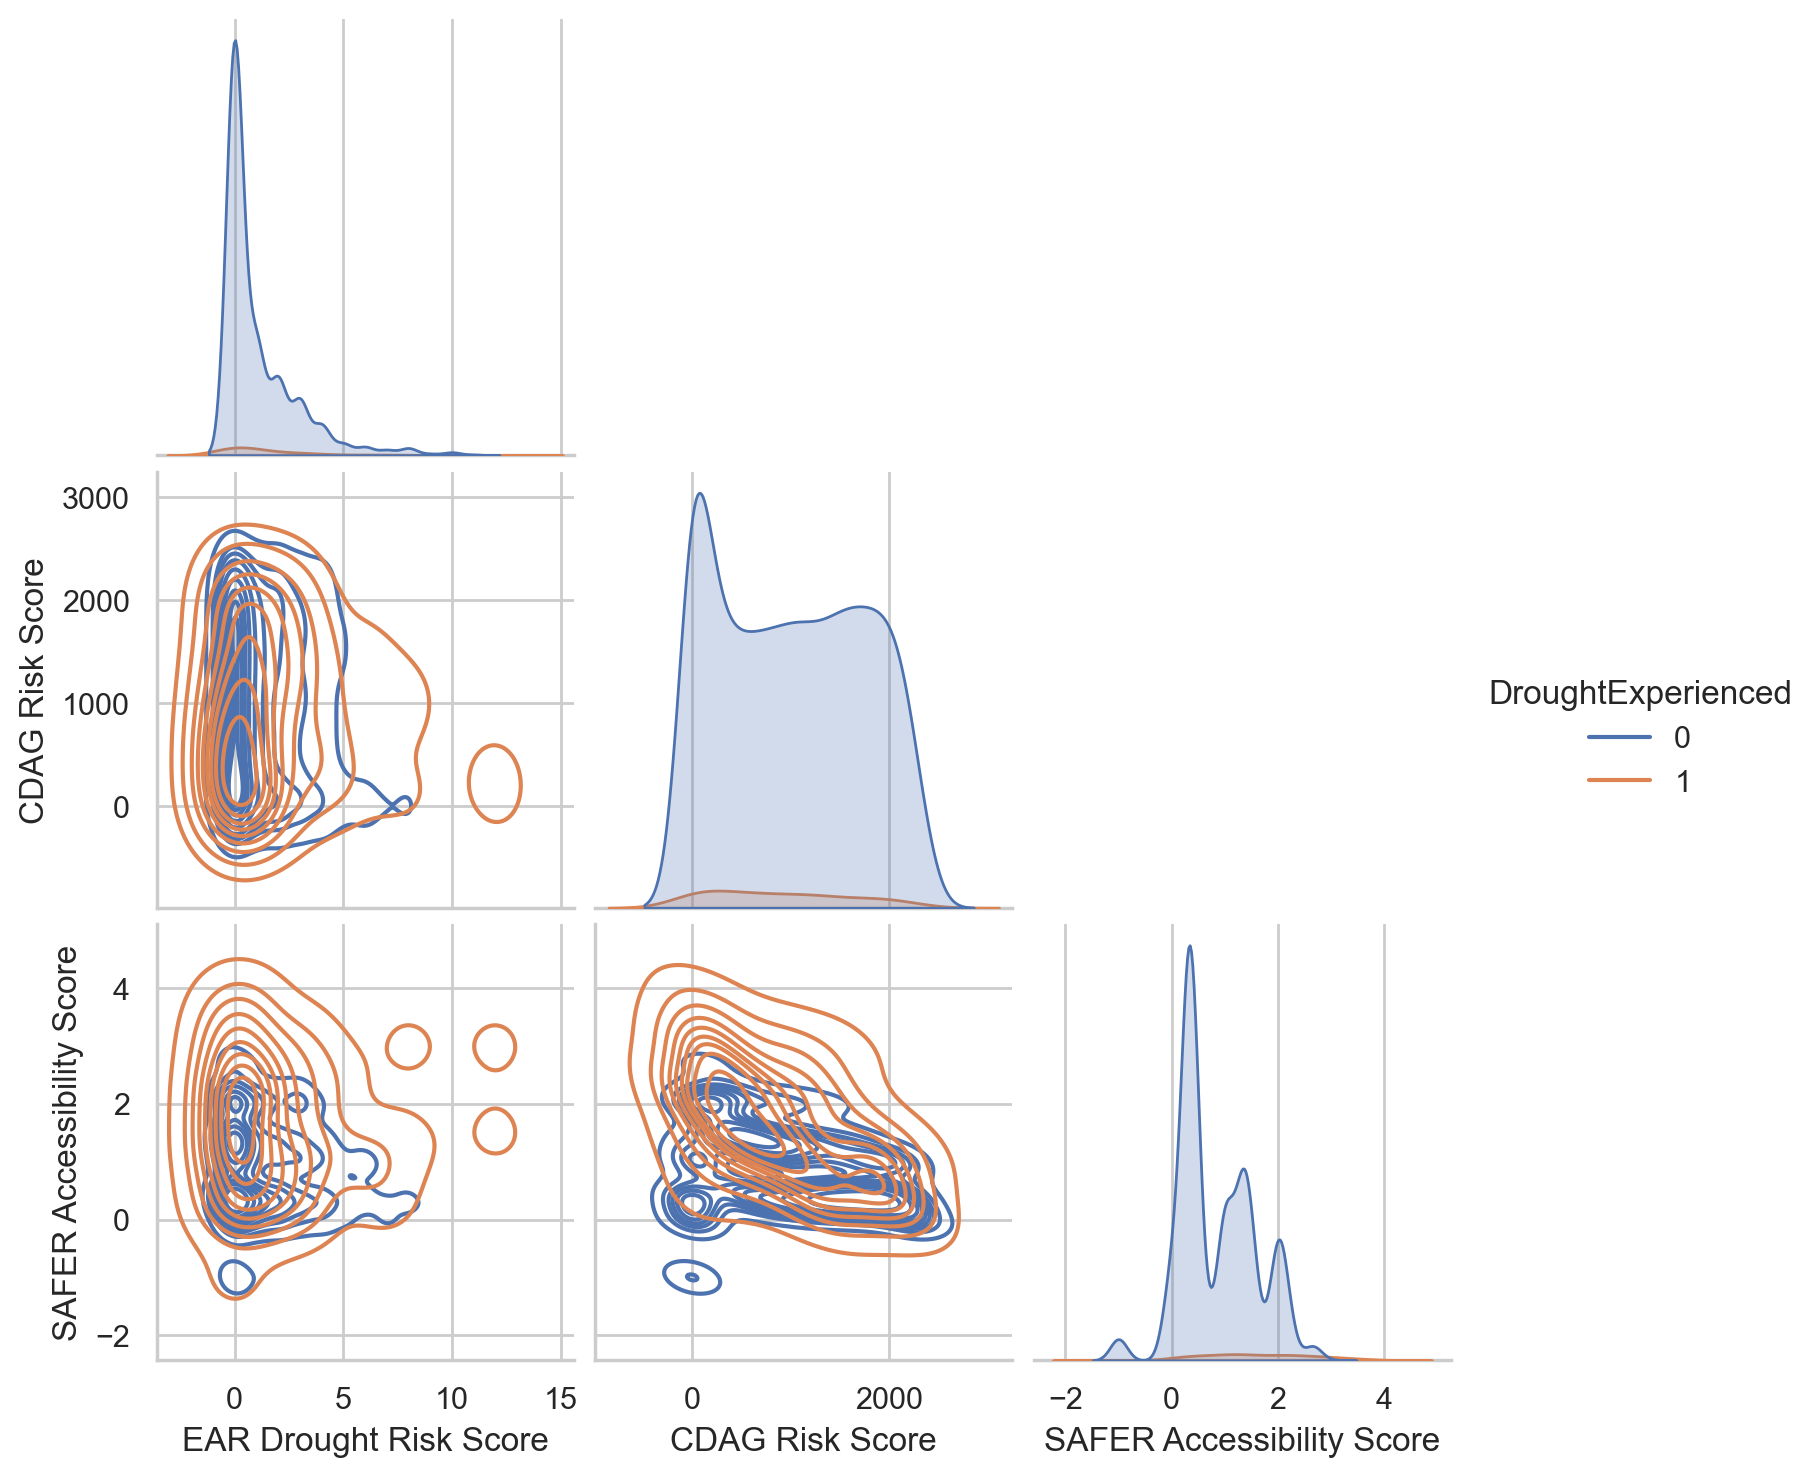

In [213]:
testdf = df[['DroughtExperienced', 'EAR2020DroughtRiskScore', 'CDAG_rank', 'SAFER_AccessibilityScore']]
testdf = testdf.rename(columns={'EAR2020DroughtRiskScore':'EAR Drought Risk Score', 'CDAG_rank': 'CDAG Risk Score', 'SAFER_AccessibilityScore': 'SAFER Accessibility Score'})
sns.pairplot(testdf, kind='kde', hue='DroughtExperienced', corner=True, plot_kws=dict(common_norm=False))#.savefig('kde.png', dpi=300, transparent=True, bbox_inches='tight')

Look at the features together with the each consituent outcome label.

Right now, the outcome label `DroughtExperienced` equals 1 if any of the following consituent outcomes equal 1:  `WaterOutageDroughtViolat|ion'`, `BottledHauledWaterOrZeroSource`, `CurtailmentExemptionPetition`, `Score_1704`, `FundedProject`. Otherwise, `DroughtExperienced` equals zero.

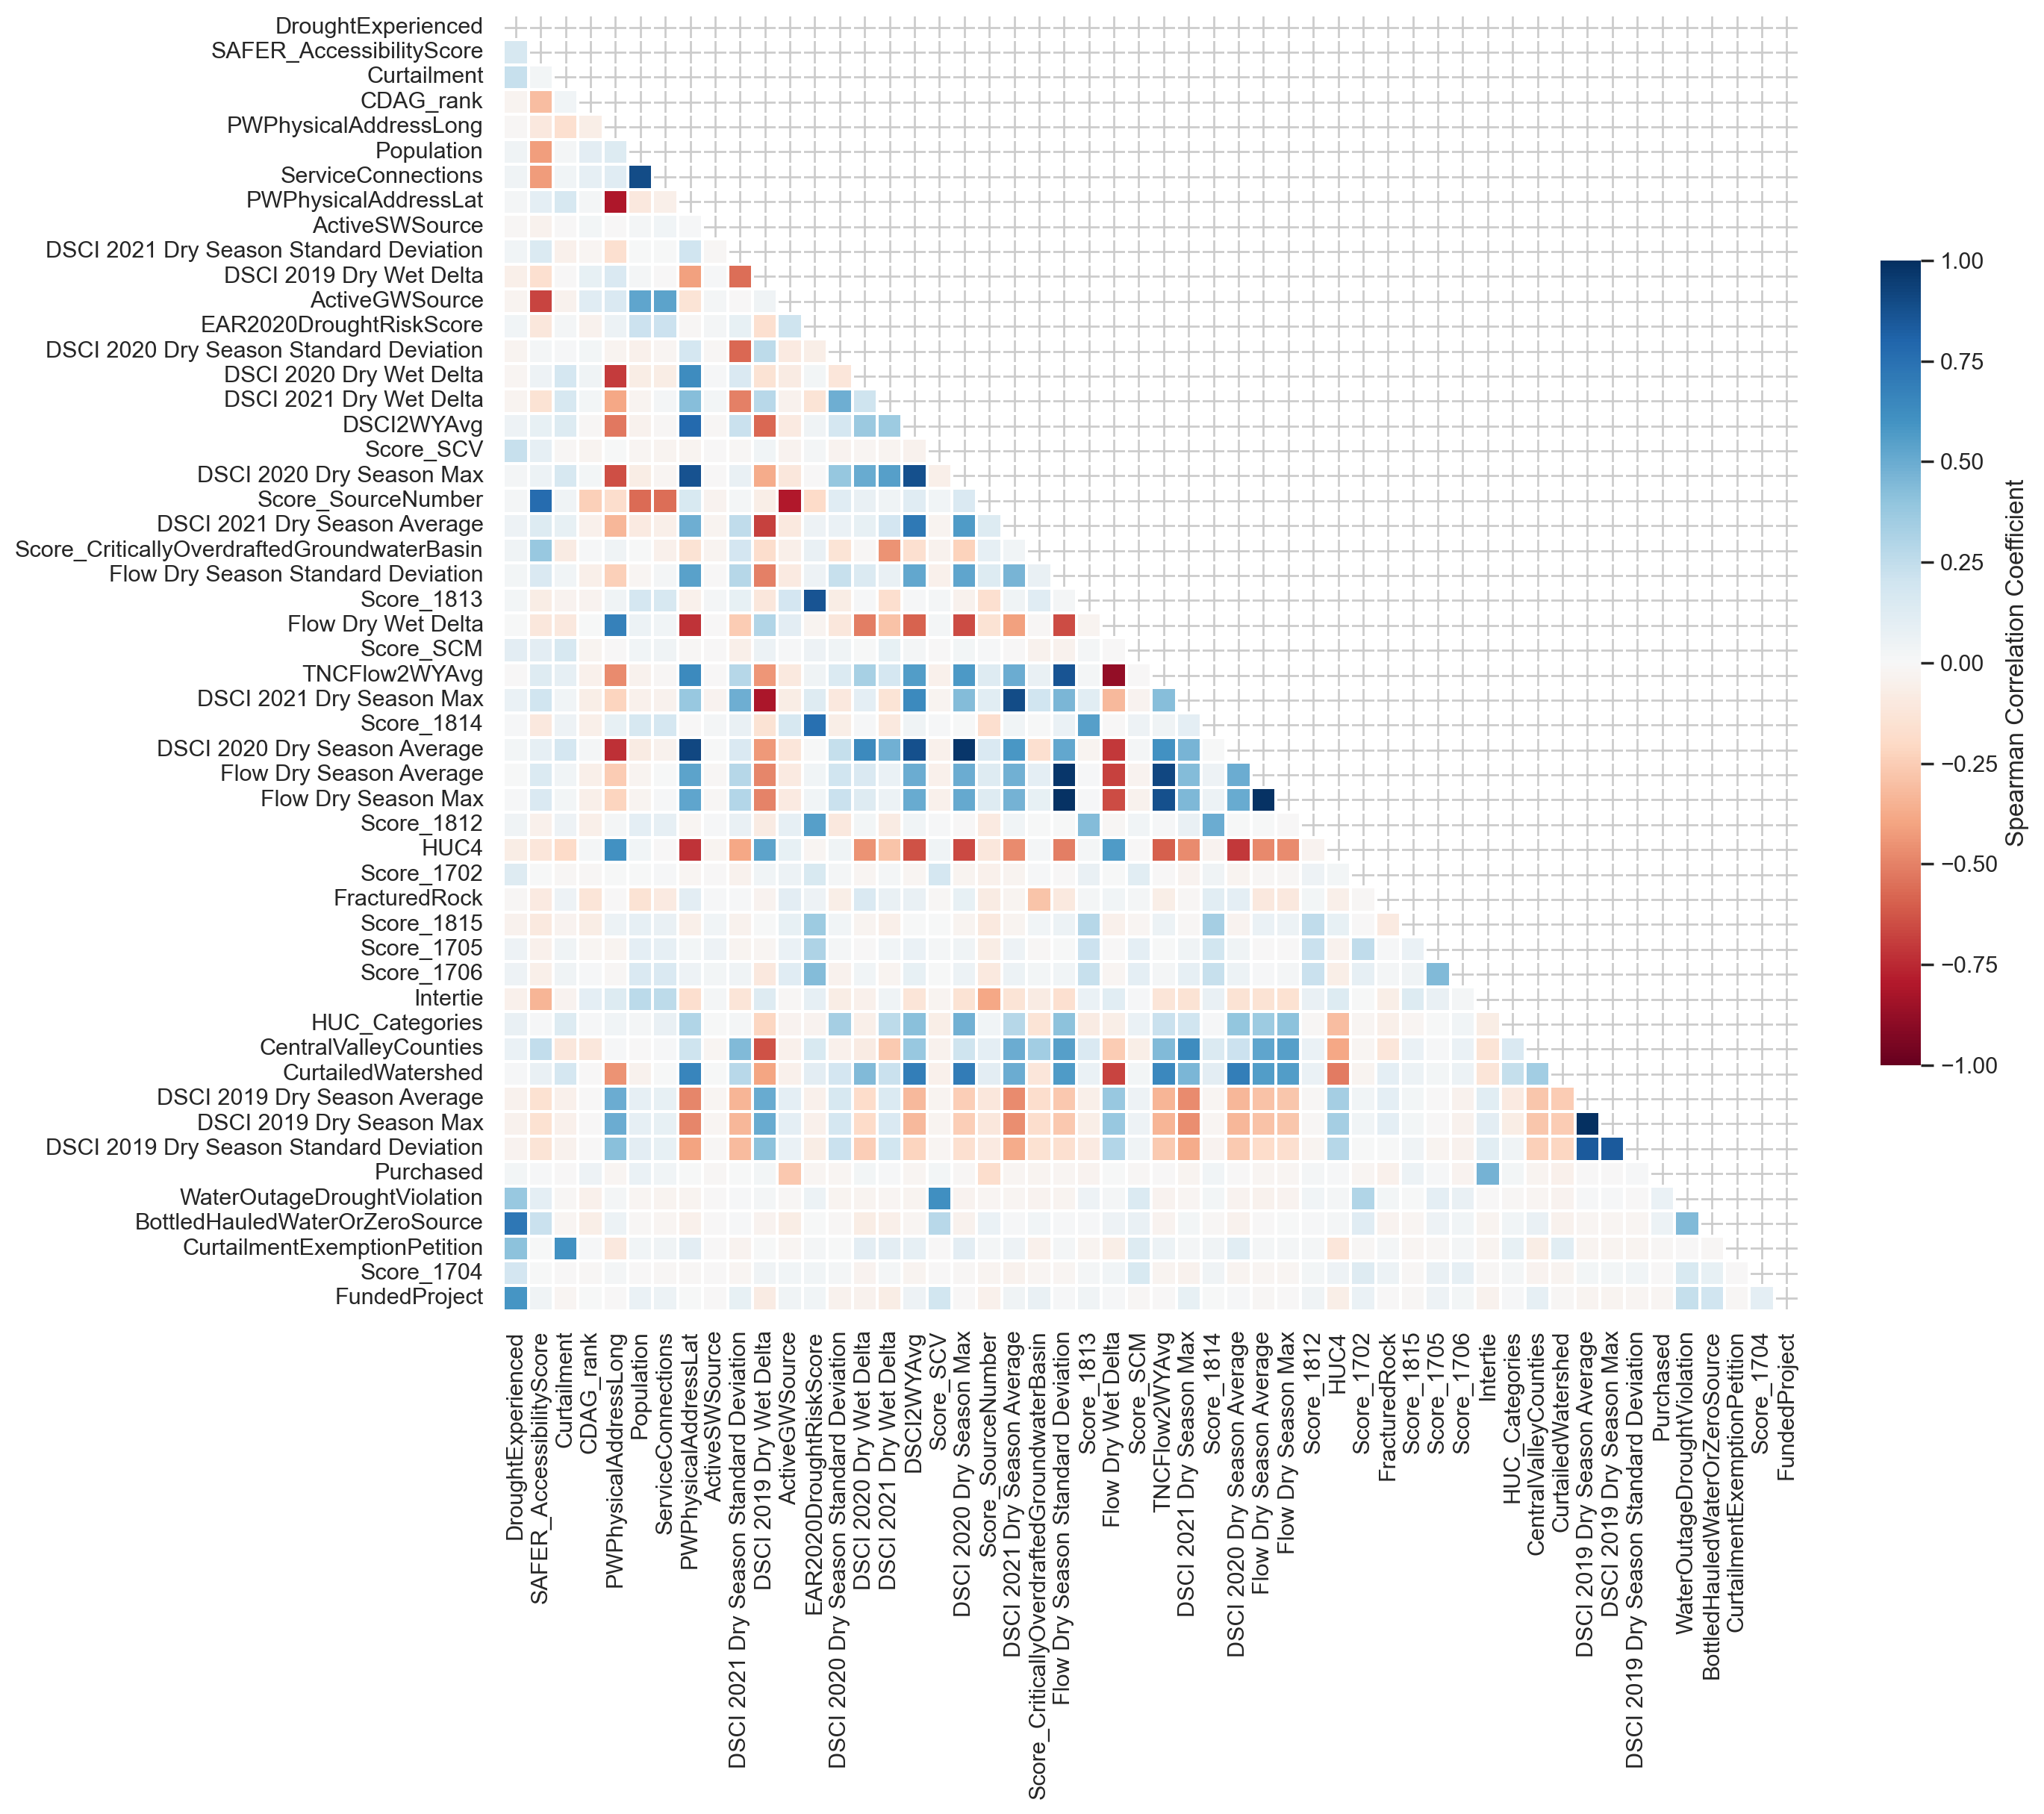

In [229]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.set_theme(style="white")

# Calculate Spearman correlation coefficient
corr = df_all.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot Spearman correlation coefficient as a diagonal heatmap
cmap = sns.color_palette('RdBu', as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.75, cbar_kws={"shrink": .5, "label": 'Spearman Correlation Coefficient'})
fig.savefig('spearman_with_labels_v2.png', dpi=300, transparent=True, bbox_inches='tight')

### Split the data

Split the data into a training and a validation set.

In [41]:
y = df['DroughtExperienced']

In [42]:
X = df.drop(columns = 'DroughtExperienced')

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7, shuffle=True)

In [44]:
print(f"The training set is {len(X_train)/len(X)*100}% of the data.")
print(f"The validation set is {len(X_val)/len(X)*100}% of the data.")

The training set is 69.9930216329379% of the data.
The validation set is 30.00697836706211% of the data.


### Scale the data

Scale the numeric features assuming the data obey a Gaussian distribution (is this is a reasonably fair assumption?). Leave the categorical features unscaled.

In [45]:
numeric_features = [
    'ServiceConnections', 'Population', 'CDAG_rank',
    'SAFER_AccessibilityScore', 'ActiveGWSource', 'ActiveSWSource',
    'DSCI2WYAvg', 'TNCFlow2WYAvg', 
    'PWPhysicalAddressLat', 'PWPhysicalAddressLong', 
    'Flow Dry Season Max', 
    'Flow Dry Season Average', 'Flow Dry Season Standard Deviation', 'Flow Dry Wet Delta', 
    'DSCI 2021 Dry Season Max', 'DSCI 2021 Dry Season Average',
    'DSCI 2021 Dry Season Standard Deviation', 'DSCI 2021 Dry Wet Delta',
    'DSCI 2020 Dry Season Max', 'DSCI 2020 Dry Season Average',
    'DSCI 2020 Dry Season Standard Deviation', 'DSCI 2020 Dry Wet Delta',
    'DSCI 2019 Dry Season Max', 'DSCI 2019 Dry Season Average',
    'DSCI 2019 Dry Season Standard Deviation', 'DSCI 2019 Dry Wet Delta'#, 'gwe_avg', 'num_purchases_monthly', 'num_sales_monthly'
]

# categorical_features = []
categorical_features = ['Score_SourceNumber', 'Score_SCV',
       'Score_SCM', 'Score_CriticallyOverdraftedGroundwaterBasin', 
       'Curtailment', 'Score_1702', 'Score_1705', 'Score_1706', 'Score_1812',
       'Score_1813', 'Score_1814', 'Score_1815', 'EAR2020DroughtRiskScore',
       'CurtailedWatershed', 'HUC4', 'FracturedRock', 'Intertie',
       'CentralValleyCounties', 'HUC_Categories',
                       ]

all_features = numeric_features + categorical_features

In [46]:
if (len(numeric_features) + len(categorical_features)) == len(X.columns):
    print('All variables are included.')

All variables are included.


Select and scale the numeric features.

In [47]:
scaler = preprocessing.StandardScaler()

In [48]:
X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

Scale the validation set using the same mean and variance as the training set.

In [49]:
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

Append the unscaled categorical features.

In [50]:
X_train_categorical = np.array(X_train[categorical_features])
X_val_categorical = np.array(X_val[categorical_features])

In [51]:
X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)

In [52]:
X_train_scaled.shape, X_val_scaled.shape

((2006, 45), (860, 45))

### Train the model

* Using a RandomForestClassifier and same parameter values for now to mimic the original DDW model

In [53]:
y_train.value_counts()

0    1892
1     114
Name: DroughtExperienced, dtype: int64

In [54]:
class_weight = {0: 1, 1: 1}

In [55]:
#clf = RandomForestClassifier(max_features=len(all_features), n_estimators=770, n_jobs=-1, random_state=42, class_weight=class_weight)
clf = RandomForestClassifier(max_features=len(all_features), n_estimators=770, n_jobs=-1, random_state=42)

In [56]:
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_features=45, n_estimators=770, n_jobs=-1,
                       random_state=42)

In [57]:
y_pred = clf.predict(X_val_scaled)

### Question 1: What are the most predictive features?

* In the original model, the most predictive features were static over time.
* After some feature engineering, our model shows that the most predictive features vary with time.
* We assess predictive capacity based on two metrics: the Univariate Fisher / ANOVA F Score or Gini Impurity Importance. Some features rank high on one measure, but low on the other. 

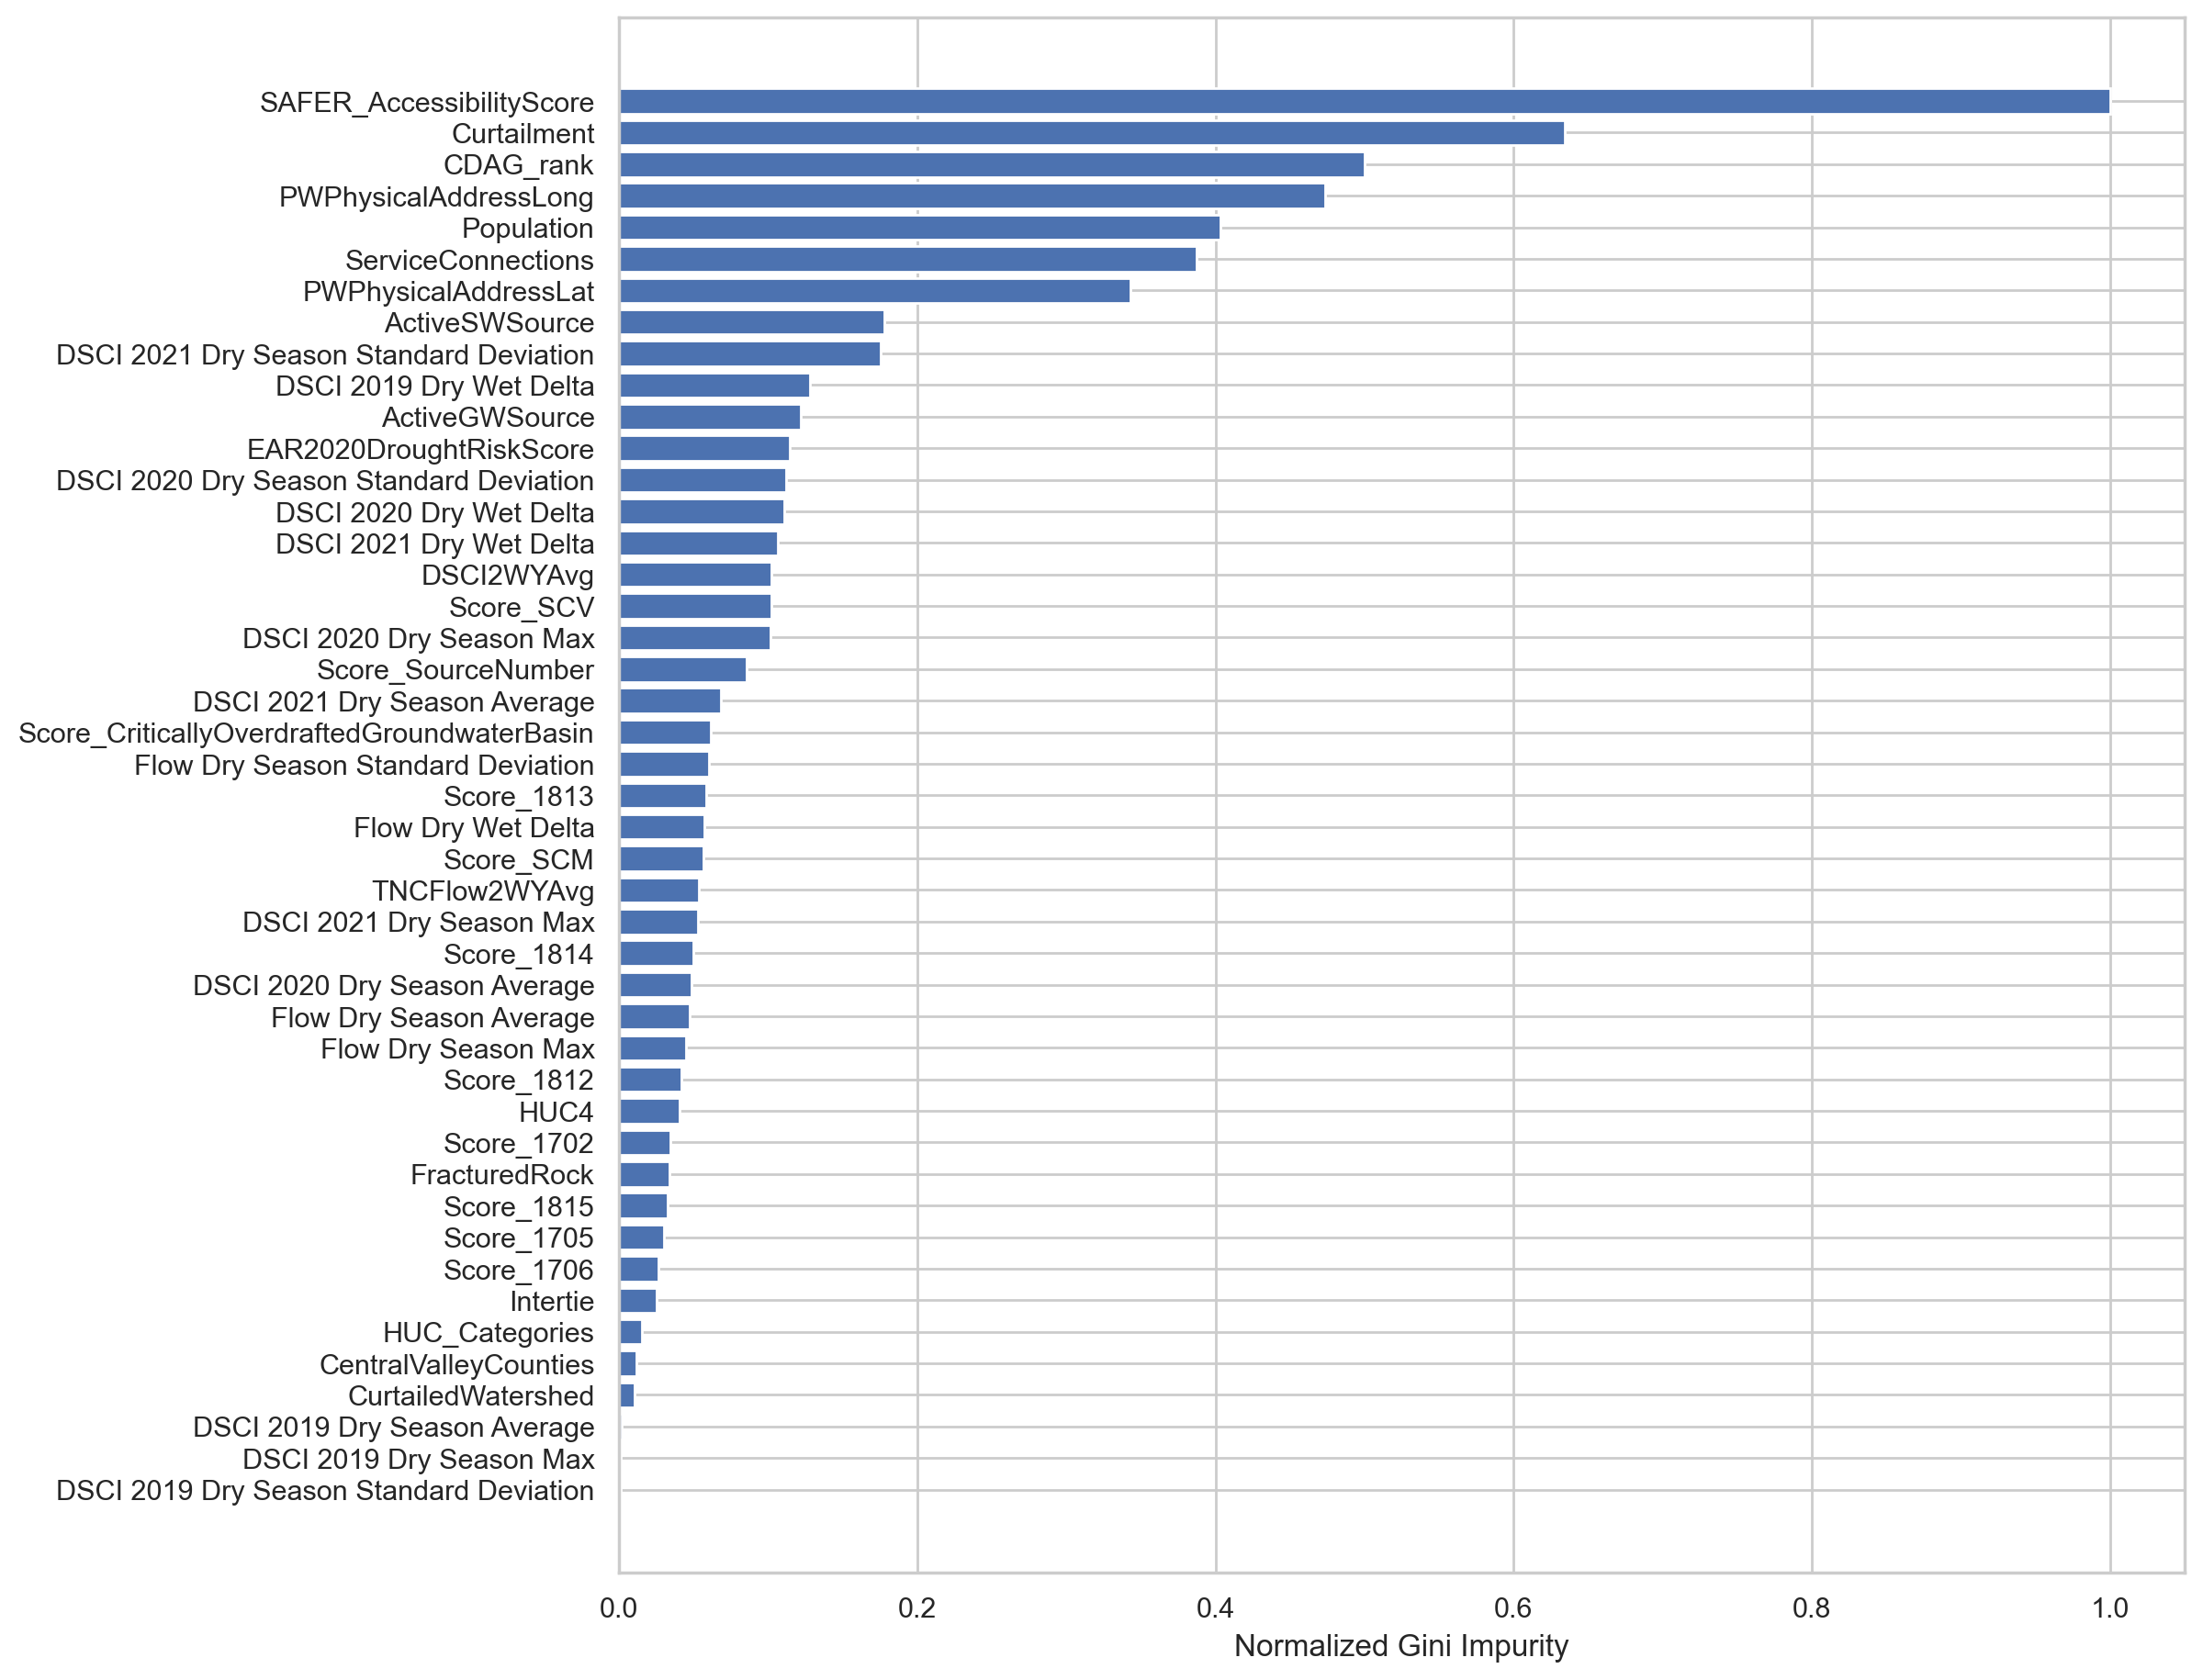

In [58]:
fig, ax = plt.subplots(figsize=(11,11))
sns.set_theme(style='whitegrid')

features = all_features # Note that this is the correct order of feature names
scores_gini = clf.feature_importances_

order = np.argsort(scores_gini)
ordered_features_gini = [features[i] for i in order]
ordered_normalized_scores_gini = sorted(scores_gini/np.nanmax(scores_gini))
ordered_scores_gini = sorted(scores_gini)

ax.barh(ordered_features_gini, ordered_normalized_scores_gini)
ax.set(xlabel = 'Normalized Gini Impurity')
fig.savefig('Gini_onlydroughtflow_gwandsw.png', dpi=300, transparent=True, bbox_inches='tight')

In [59]:
print(np.nanmax(ordered_scores_gini))
print(np.nanmax(ordered_scores_fisher))

0.16276995610475356
291.21708312587566


In [60]:
df_gini_scores = pd.DataFrame({'Scores': ordered_normalized_scores_gini, 'Features': ordered_features_gini, 'Type': ['Gini'] * len(ordered_features_gini)})
df_fisher_scores = pd.DataFrame({'Scores': ordered_normalized_scores_fisher, 'Features': ordered_features_fisher, 'Type': ['Fisher'] * len(ordered_features_fisher)})
df_scores = df_gini_scores.append(df_fisher_scores).reset_index().drop(columns=['index'])

/var/folders/93/hbnl0wps0mg_sqnmv_jpnwlm0000gq/T/ipykernel_4996/1147281427.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


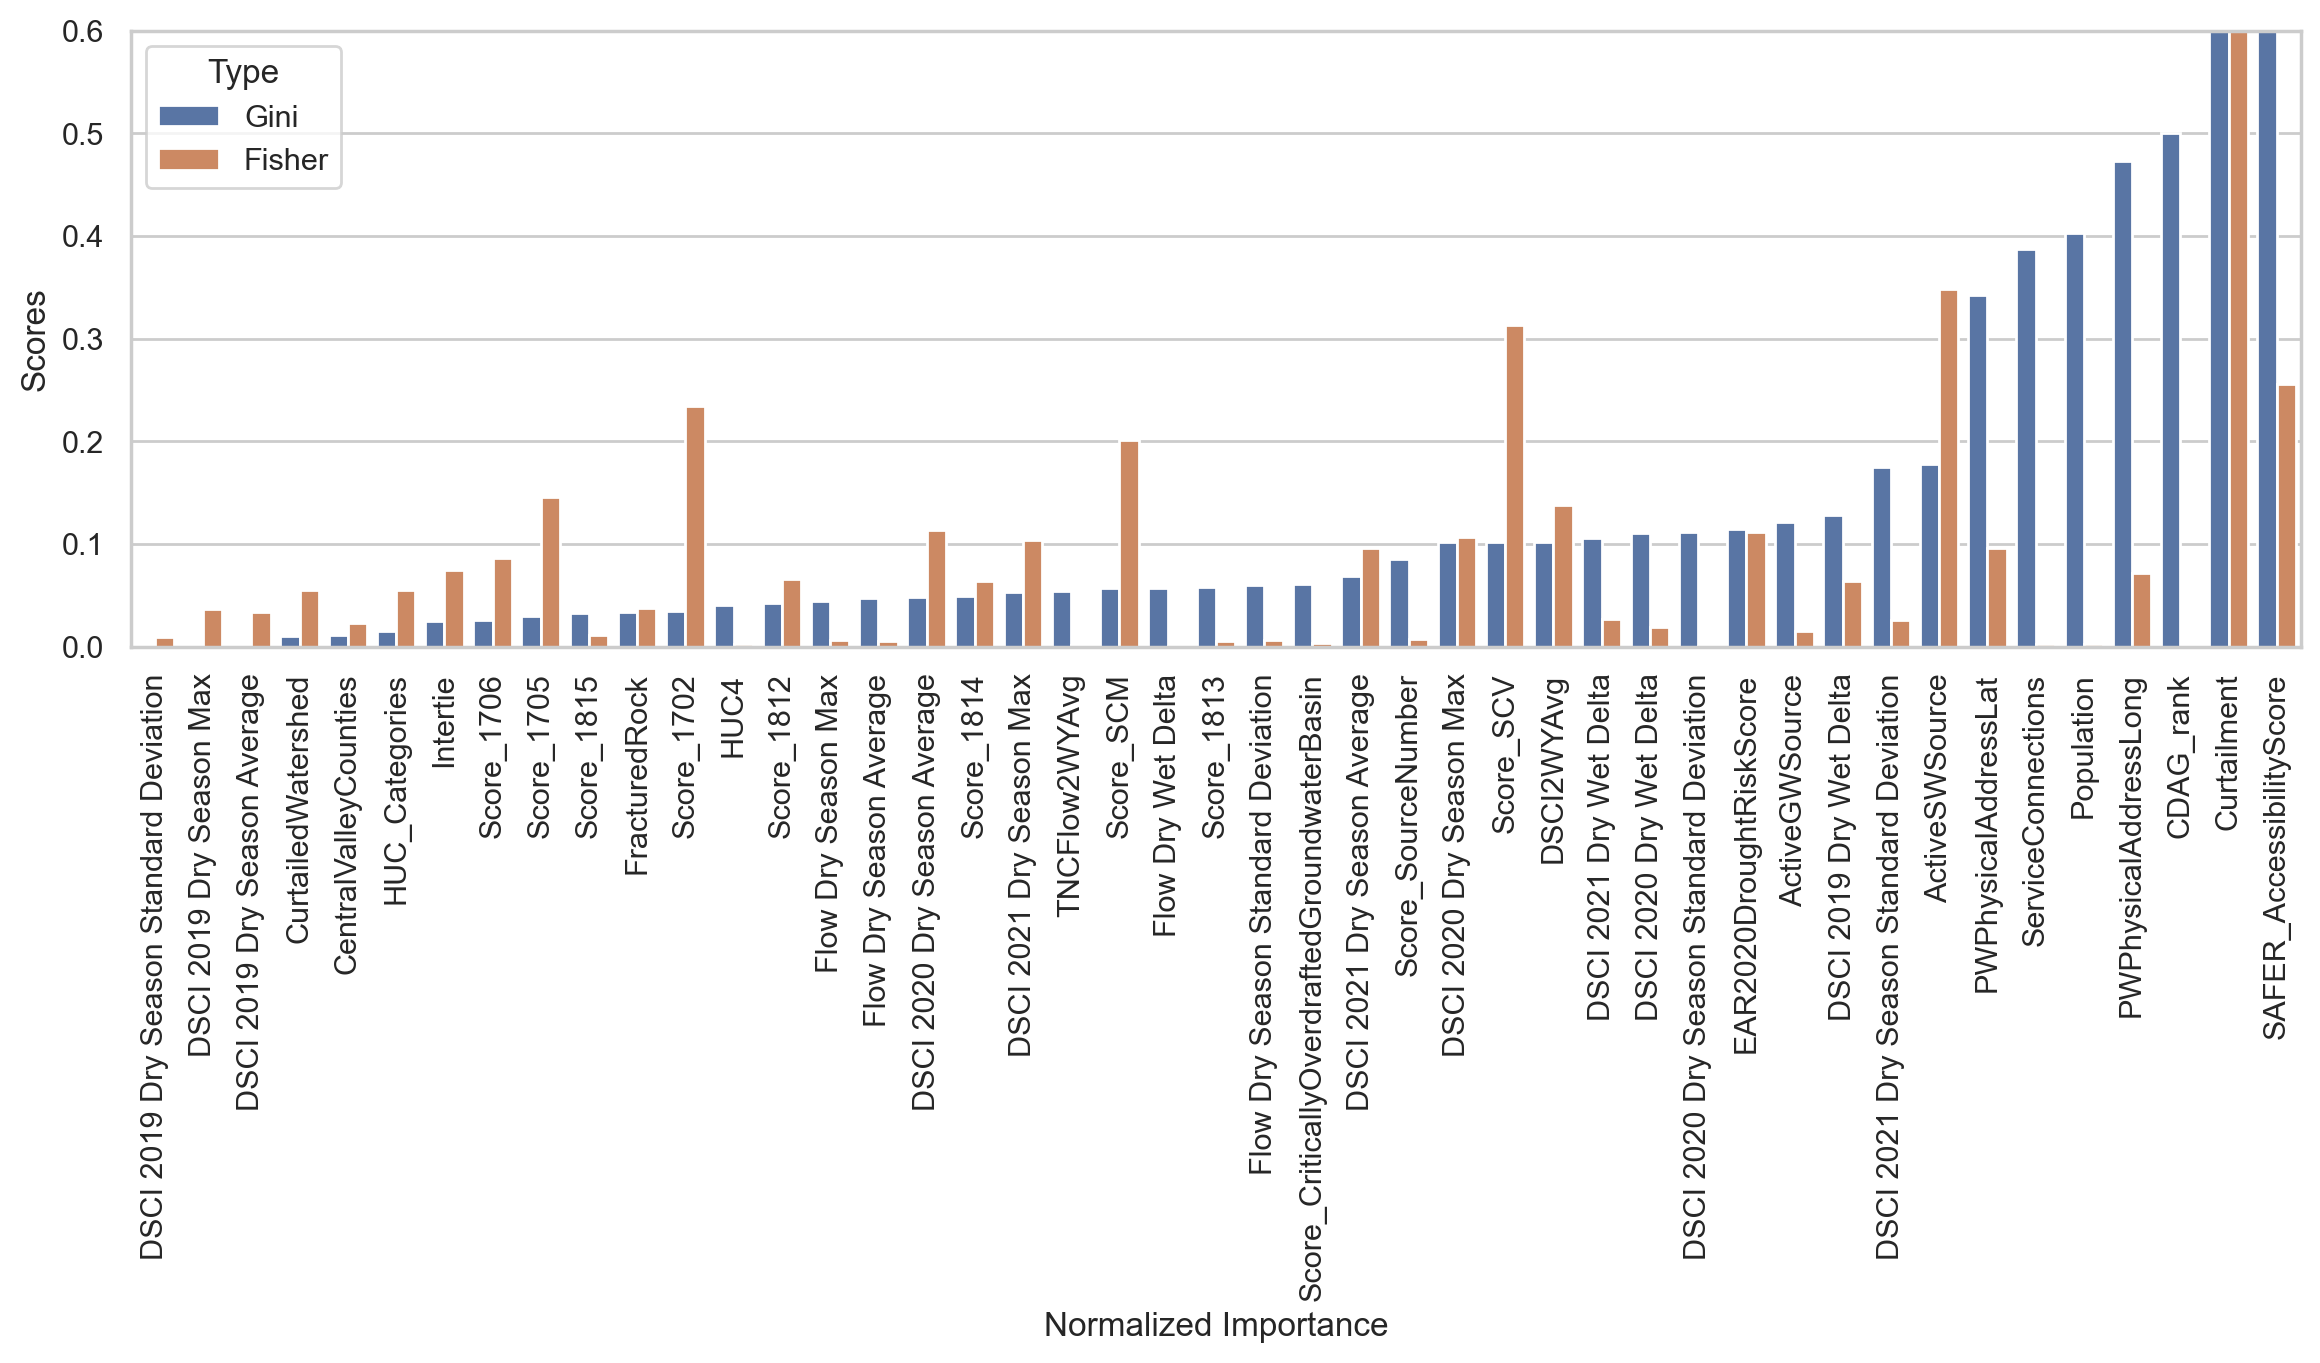

In [61]:
fig, ax = plt.subplots(figsize=(14,4))
sns.set_theme(style='whitegrid')

sns.barplot(orient="v", data=df_scores, x='Features', y='Scores', hue='Type')
ax.set(xlabel = 'Normalized Importance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
ax.set_ylim([0,0.6])
fig.savefig('Gini_and_Fisher_groundwater_and_surfacewater.png', dpi=300, transparent=True, bbox_inches='tight')

Compare this to the features and scores in the previous model from the DDW ([see this Google sheet](https://docs.google.com/spreadsheets/d/17ZfqKys9XS0KR57rUTjGyJjk16dcf8GelyIgt_MYjVY/edit#gid=0)):

### Question 2: Does the model perform well?

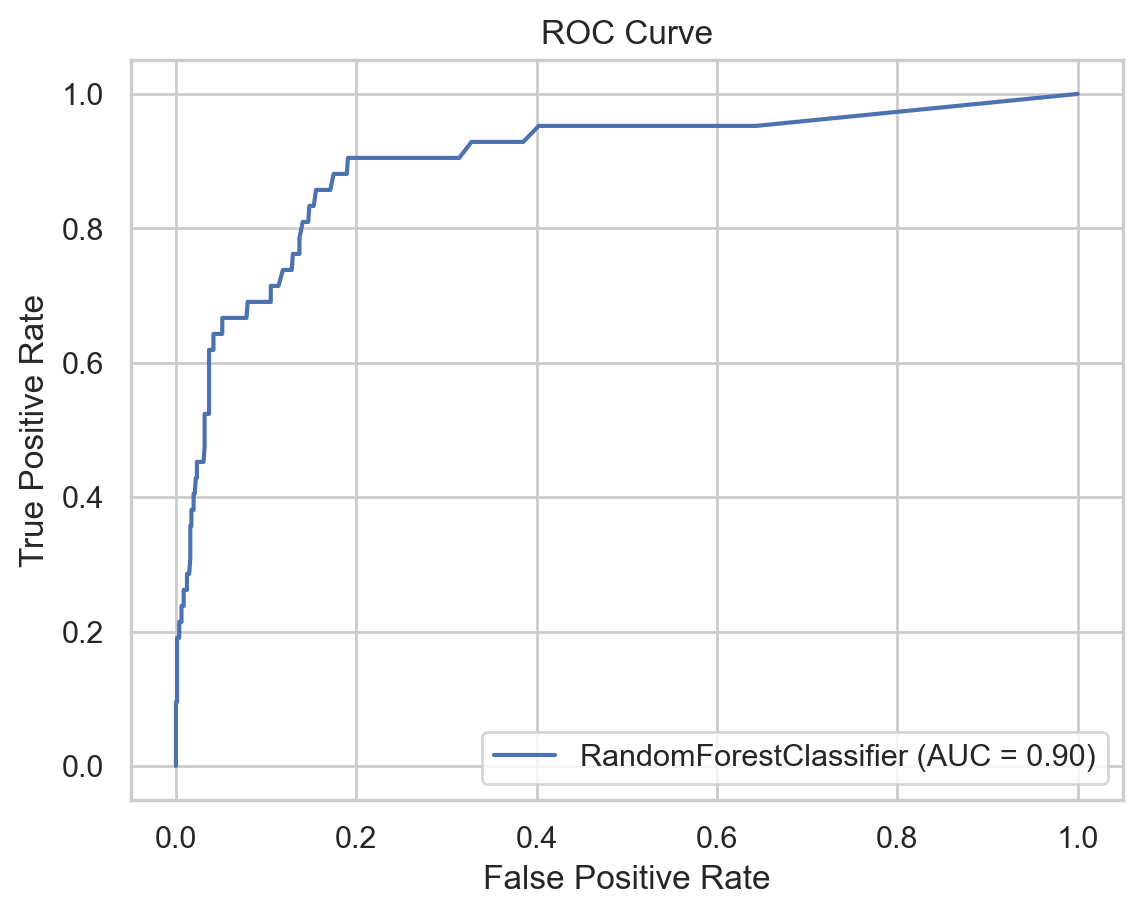

In [62]:
fig, ax = plt.subplots()
rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
plt.show()

### Question 3: What predictions does the model get wrong?

Some observations:
* False negatives serve small populations (less than 2000 people) with a seemingly high ratio of population to service connections. All but one was curtailed in the past.
* None of the false positives had a service connection moratorium in the past three years.

In [63]:
y_val_out = y_val.reset_index()

In [139]:
count = 0
count_false_positive = 0
count_false_negative = 0
count_true_positive = 0
count_true_negative = 0
examples = []
examples_false_positive = []
examples_false_negative = []
examples_true_positive = []
examples_true_negative = []
for i in range(len(y_pred)):
    if y_val_out.loc[i]['DroughtExperienced'] != y_pred[i]:
        #print(y_val_out.loc[i]['DroughtExperienced'], y_pred[i], y_val_out.loc[i]['index'])
        count += 1
        examples.append(y_val_out.loc[i]['index'])
    if (y_val_out.loc[i]['DroughtExperienced'] == 1.0) and (y_pred[i] == 0.0):
        count_false_positive += 1
        examples_false_positive.append(y_val_out.loc[i]['index'])        
    if (y_val_out.loc[i]['DroughtExperienced'] == 0.0) and (y_pred[i] == 1.0):
        count_false_negative += 1    
        examples_false_negative.append(y_val_out.loc[i]['index'])
    if (y_val_out.loc[i]['DroughtExperienced'] == 1.0) and (y_pred[i] == 1.0):
        count_true_positive += 1
        examples_true_positive.append(y_val_out.loc[i]['index'])        
    if (y_val_out.loc[i]['DroughtExperienced'] == 0.0) and (y_pred[i] == 0.0):
        count_true_negative += 1    
        examples_true_negative.append(y_val_out.loc[i]['index'])
print("Number of misclassifications:", count)
print("Number of false positives:", count_false_positive)
print("Number of false negatives:", count_false_negative)
print("Number of true positives:", count_true_positive)
print("Number of true negatives:", count_true_negative)
print("Number of correct classifications:", (len(y_pred) - count))

Number of misclassifications: 42
Number of false positives: 30
Number of false negatives: 12
Number of true positives: 12
Number of true negatives: 806
Number of correct classifications: 818


In [147]:
df_false_positives = df.loc[examples_false_positive].reset_index(drop=True).assign(Classification='False Positive')
df_false_negatives = df.loc[examples_false_negative].reset_index(drop=True).assign(Classification='False Negative')
df_true_positives = df.loc[examples_true_positive].reset_index(drop=True).assign(Classification='True Positive')
df_true_negatives = df.loc[examples_true_negative].reset_index(drop=True).assign(Classification='True Negative')

In [156]:
frames = [df_false_positives, df_false_negatives, df_true_positives, df_true_negatives]
df_all = pd.concat(frames)

/Users/monica.bobra/anaconda3/envs/water/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/var/folders/93/hbnl0wps0mg_sqnmv_jpnwlm0000gq/T/ipykernel_4996/1558444207.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/var/folders/93/hbnl0wps0mg_sqnmv_jpnwlm0000gq/T/ipykernel_4996/1558444207.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


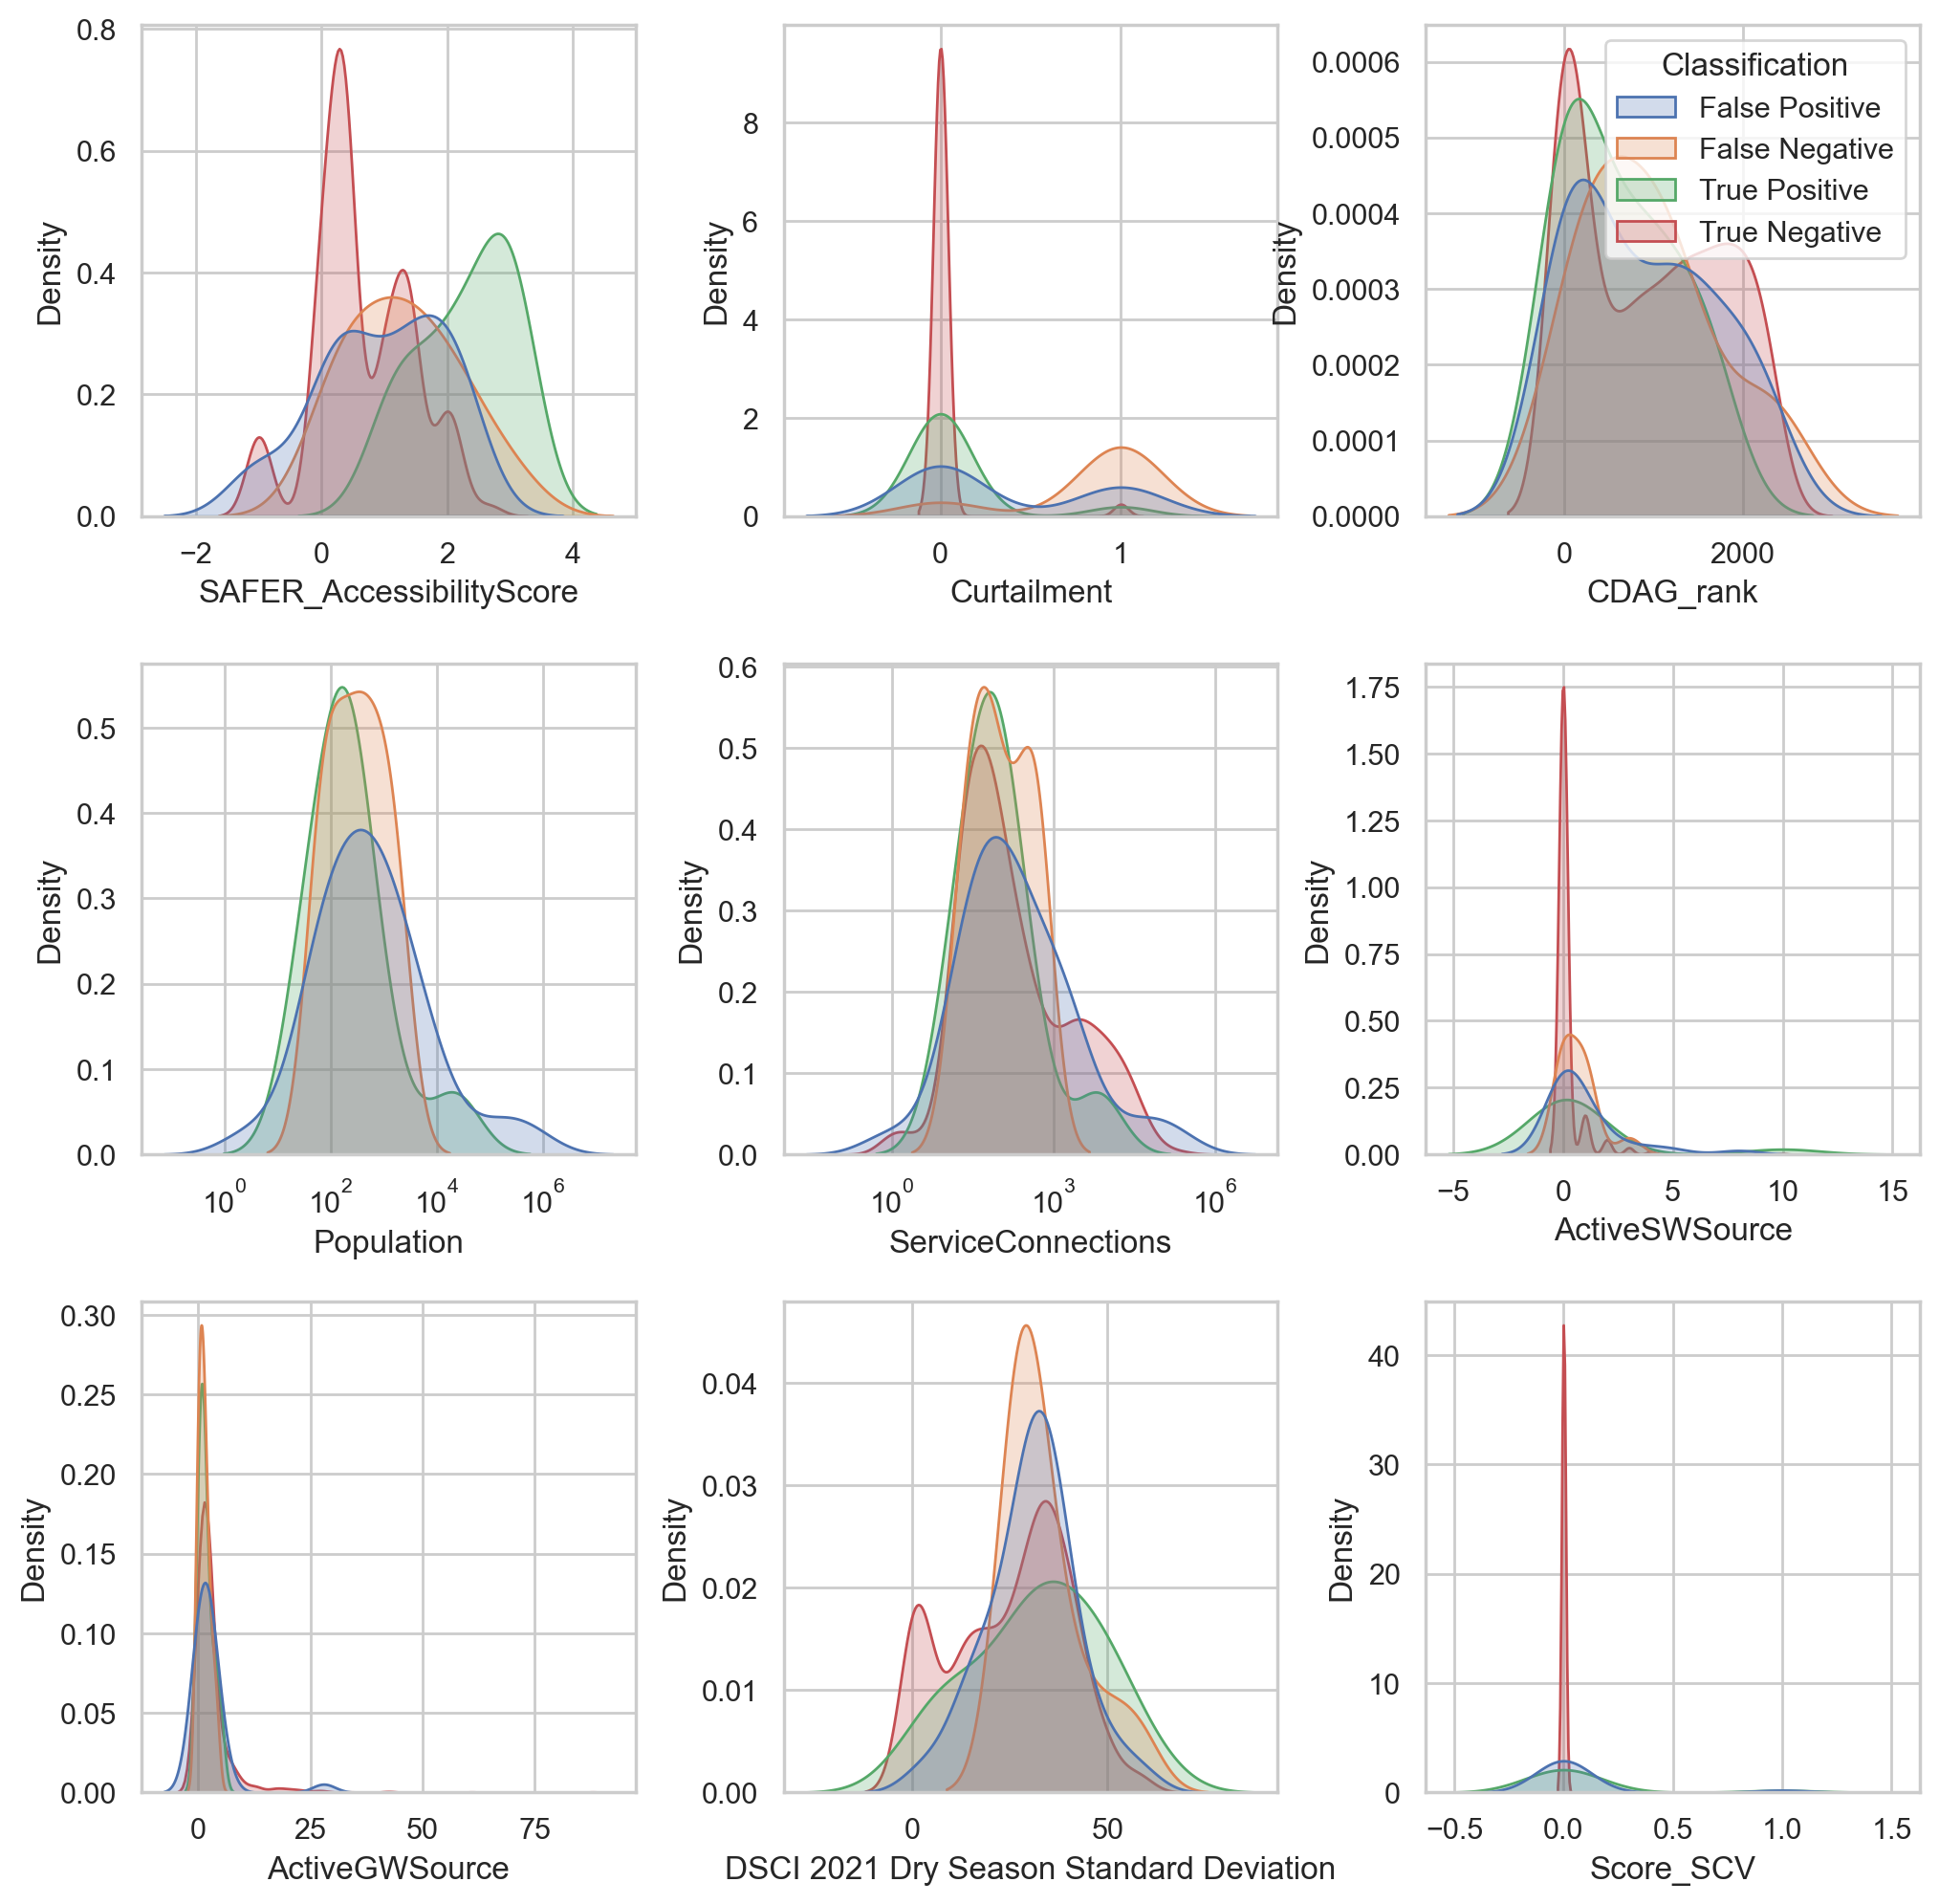

In [162]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
sns.kdeplot(df_all, x='SAFER_AccessibilityScore', hue='Classification', fill=True, ax=ax[0,0], legend=False, common_norm=False)
sns.kdeplot(df_all, x='Curtailment', hue='Classification', fill=True, ax=ax[0,1], legend=False, common_norm=False)
sns.kdeplot(df_all, x='CDAG_rank', hue='Classification', fill=True, ax=ax[0,2], legend=True, common_norm=False)
sns.kdeplot(df_all, x='Population', hue='Classification', fill=True, ax=ax[1,0], log_scale=True, legend=False, common_norm=False)
sns.kdeplot(df_all, x='ServiceConnections', hue='Classification', fill=True, ax=ax[1,1], log_scale=True, legend=False, common_norm=False)
sns.kdeplot(df_all, x='ActiveSWSource', hue='Classification', fill=True, ax=ax[1,2], legend=False, common_norm=False)
sns.kdeplot(df_all, x='ActiveGWSource', hue='Classification', fill=True, ax=ax[2,0], legend=False, common_norm=False)
sns.kdeplot(df_all, x='DSCI 2021 Dry Season Standard Deviation', hue='Classification', fill=True, ax=ax[2,1], legend=False, common_norm=False)
sns.kdeplot(df_all, x='Score_SCV', hue='Classification', fill=True, ax=ax[2,2], legend=False, common_norm=False)
plt.subplots_adjust(hspace=0.3, wspace=0.3)

### Question 4: Do more features improve model performance?

In [357]:
print("The model has",len(features),"features.")
print("These are the features, in order of Gini Importance:", ordered_features_gini)

The model has 45 features.
These are the features, in order of Gini Importance: ['DSCI 2019 Dry Season Standard Deviation', 'DSCI 2019 Dry Season Max', 'DSCI 2019 Dry Season Average', 'CurtailedWatershed', 'CentralValleyCounties', 'HUC_Categories', 'Intertie', 'Score_1706', 'Score_1705', 'Score_1815', 'FracturedRock', 'Score_1702', 'HUC4', 'Score_1812', 'Flow Dry Season Max', 'Flow Dry Season Average', 'DSCI 2020 Dry Season Average', 'Score_1814', 'DSCI 2021 Dry Season Max', 'TNCFlow2WYAvg', 'Score_SCM', 'Flow Dry Wet Delta', 'Score_1813', 'Flow Dry Season Standard Deviation', 'Score_CriticallyOverdraftedGroundwaterBasin', 'DSCI 2021 Dry Season Average', 'Score_SourceNumber', 'DSCI 2020 Dry Season Max', 'Score_SCV', 'DSCI2WYAvg', 'DSCI 2021 Dry Wet Delta', 'DSCI 2020 Dry Wet Delta', 'DSCI 2020 Dry Season Standard Deviation', 'EAR2020DroughtRiskScore', 'ActiveGWSource', 'DSCI 2019 Dry Wet Delta', 'DSCI 2021 Dry Season Standard Deviation', 'ActiveSWSource', 'PWPhysicalAddressLat', 'Servi

In [262]:
auc_values = []
auc_std = []
for i in range(len(ordered_features_gini)):
    # Select the data
    y = df['DroughtExperienced']
    X = df[ordered_features_gini[i:]]
    total_features = X.columns.to_list()
    
    auc_scores = []
    for j in range(3):    # This should eventually be 100
        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True)

        # Identify the numeric and categorical features
        total_numeric_features = list(set(total_features).intersection(numeric_features))
        total_categorical_features = list(set(total_features).intersection(categorical_features))

        # Select and scale the numeric features
        if total_numeric_features:
            scaler = preprocessing.StandardScaler()
            X_train_numeric = X_train[total_numeric_features]
            X_val_numeric = X_val[total_numeric_features]
            X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
            X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

        # Select the categorical features
        if total_categorical_features:
            X_train_categorical = np.array(X_train[total_categorical_features])
            X_val_categorical = np.array(X_val[total_categorical_features])

        # Create training and validation sets
        if total_numeric_features and total_categorical_features:
            X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
            X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)
        if total_numeric_features and not total_categorical_features:
            X_train_scaled = X_train_numeric_scaled
            X_val_scaled = X_val_numeric_scaled
        if not total_numeric_features and total_categorical_features:
            X_train_scaled = X_train_categorical
            X_val_scaled = X_val_categorical

        # Train the model
        clf = RandomForestClassifier(max_features=46, n_estimators=770, n_jobs=-1, random_state=42)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_val_scaled)

        # Calculate the AUC
        rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba');
        auc_scores.append(rfc_disp.roc_auc)
        
    auc_std.append(np.std(auc_scores))
    auc_values.append(np.mean(auc_scores))
    print(i,np.mean(auc_scores), np.std(auc_scores))

0 0.8646435943010476 0.048195469019017244
1 0.884501603743202 0.01532800194311695
2 0.8569400426220394 0.018291273408917567
3 0.9111054530129467 0.010866154204768847
4 0.8985855463494516 0.012111858349705198
5 0.8990766098988964 0.01455137227068504
6 0.9020644962449899 0.03142417660114977
7 0.8962447687150377 0.03247821776838295
8 0.8822639231774895 0.039708690975482665
9 0.9043195724202097 0.011506506916400247
10 0.9009297216890039 0.015338912558121
11 0.8596176777720935 0.013192435219658018
12 0.8578141128324175 0.023611145737741254
13 0.8807444779384542 0.04522022116915201
14 0.8882850086030266 0.033453212750208794
15 0.8654041314999089 0.024508027323898705
16 0.8812917303552057 0.023617993792655483
17 0.8393384578793674 0.0074500870252715784
18 0.8900898083473218 0.029294879541669726
19 0.898476719259822 0.016963886514461766
20 0.881200227929623 0.038472644414385505
21 0.9044925831119105 0.02623408960794753
22 0.8961421120209335 0.037693692204444205
23 0.8883264780959115 0.00494711

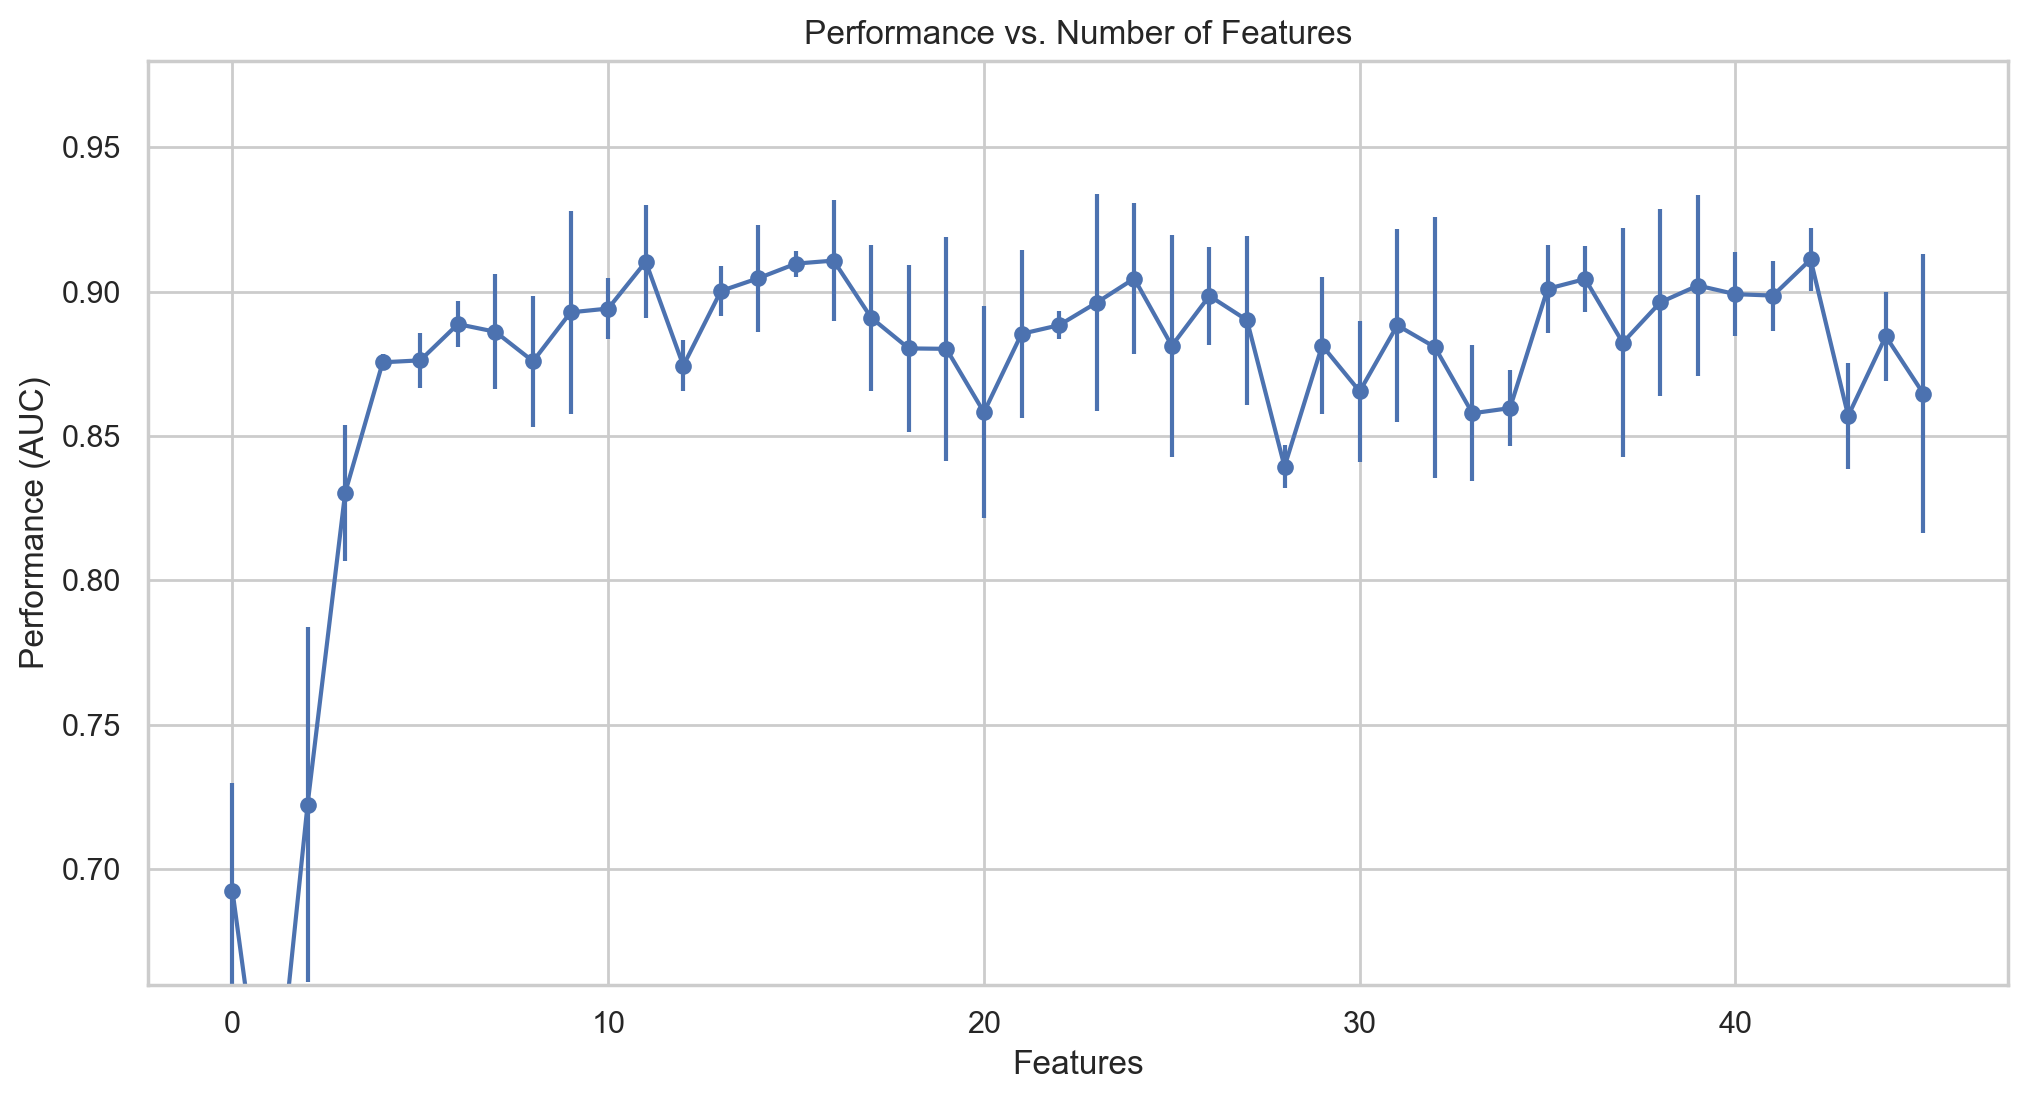

In [265]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(np.arange(45),np.flip(auc_values), yerr=np.flip(auc_std), marker=".", markersize=10)
ax.set_xlabel('Features')
ax.set_ylabel('Performance (AUC)')
ax.set_title('Performance vs. Number of Features')
ax.set_ylim([0.66, 0.98])
fig.savefig('performancevsfeatures.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 6: Do different labels improve model performance?

In [455]:
print("Number of positive examples in DroughtExperienced:",len(df_all[df_all['DroughtExperienced'] == 1]))
print("Number of positive examples in WaterOutageDroughtViolation:",len(df_all[df_all['WaterOutageDroughtViolation'] == 1]))
print("Number of positive examples in BottledHauledWaterOrZeroSource:",len(df_all[df_all['BottledHauledWaterOrZeroSource'] == 1]))
print("Number of positive examples in CurtailmentExemptionPetition:",len(df_all[df_all['CurtailmentExemptionPetition'] == 1]))
print("Number of positive examples in Score_1704:",len(df_all[df_all['Score_1704'] == 1]))
print("Number of positive examples in FundedProject:",len(df_all[df_all['FundedProject'] == 1]))

Number of positive examples in DroughtExperienced: 156
Number of positive examples in WaterOutageDroughtViolation: 16
Number of positive examples in BottledHauledWaterOrZeroSource: 58
Number of positive examples in CurtailmentExemptionPetition: 42
Number of positive examples in Score_1704: 9
Number of positive examples in FundedProject: 62


In [456]:
outcome_label = [
 'DroughtExperienced',
 'WaterOutageDroughtViolation',
 'BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',
 'Score_1704',
 'FundedProject']

In [457]:
auc_values_per_label = []
auc_std_per_label = []

for k in range(len(outcome_label)):
    # Select the outcome label
    y = df_all[outcome_label[k]]
    print(outcome_label[k])

    auc_values = []
    auc_std = []
    for i in range(len(ordered_features_gini)):
        # Select the features
        X = df_all[ordered_features_gini[i:]]
        total_features = X.columns.to_list()

        auc_scores = []
        for j in range(5):    # This should eventually be 100
            # Split the data
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=7)

            # Identify the numeric and categorical features
            total_numeric_features = list(set(total_features).intersection(numeric_features))
            total_categorical_features = list(set(total_features).intersection(categorical_features))

            # Select and scale the numeric features
            if total_numeric_features:
                scaler = preprocessing.StandardScaler()
                X_train_numeric = X_train[total_numeric_features]
                X_val_numeric = X_val[total_numeric_features]
                X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
                X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

            # Select the categorical features
            if total_categorical_features:
                X_train_categorical = np.array(X_train[total_categorical_features])
                X_val_categorical = np.array(X_val[total_categorical_features])

            # Create training and validation sets
            if total_numeric_features and total_categorical_features:
                X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
                X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)
            if total_numeric_features and not total_categorical_features:
                X_train_scaled = X_train_numeric_scaled
                X_val_scaled = X_val_numeric_scaled
            if not total_numeric_features and total_categorical_features:
                X_train_scaled = X_train_categorical
                X_val_scaled = X_val_categorical

            # Train the model
            clf = RandomForestClassifier(max_features=46, n_estimators=770, n_jobs=-1, random_state=42)
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_val_scaled)

            # Calculate the AUC
            rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba');
            auc_scores.append(rfc_disp.roc_auc)
        
        auc_std.append(np.std(auc_scores))
        auc_values.append(np.mean(auc_scores))
        print(i,np.mean(auc_scores), np.std(auc_scores))

    auc_std_per_label.append(auc_std)
    auc_values_per_label.append(auc_values)

DroughtExperienced
0 0.8994789847479334 0.0
1 0.8994353242519502 0.0
2 0.8988095238095237 0.0
3 0.8984747933403192 1.1102230246251565e-16
4 0.8981400628711143 0.0
5 0.9000029106997323 0.0
6 0.9004540691582257 0.0
7 0.8994498777506112 0.0
8 0.9000465711957155 1.1102230246251565e-16
9 0.8990132727907788 1.1102230246251565e-16
10 0.8977325649086041 1.1102230246251565e-16
11 0.8953603446268483 0.0
12 0.8976597974152988 1.1102230246251565e-16
13 0.8976306904179765 0.0
14 0.899609966235883 1.1102230246251565e-16
15 0.8972959599487718 0.0
16 0.8999155897077656 1.1102230246251565e-16
17 0.8993625567586448 1.1102230246251565e-16
18 0.9002503201769706 0.0
19 0.8981837233670975 1.1102230246251565e-16
20 0.9002503201769706 1.1102230246251565e-16
21 0.8995663057398999 0.0
22 0.8999883572010712 0.0
23 0.898096402375131 0.0
24 0.8993334497613226 0.0
25 0.8987367563162184 1.1102230246251565e-16
26 0.8983438118523693 0.0
27 0.898838630806846 1.1102230246251565e-16
28 0.8977180114099429 0.0
29 0.8932064

In [540]:
df_auc = pd.DataFrame({'AUC Scores': auc_values_per_label, 'AUC Standard Deviation': auc_std_per_label, 'Outcome Label': outcome_label})

In [541]:
df_auc

AUC Scores  \
0  [0.8994789847479334, 0.8994353242519502, 0.898...   
1  [0.9864327485380118, 0.9878362573099416, 0.987...   
2  [0.9658880971232515, 0.9660530482977038, 0.965...   
3  [0.9800835207195633, 0.9800835207195631, 0.979...   
4  [0.8891228070175439, 0.8892397660818714, 0.889...   
5  [0.7706605450236967, 0.7709197274881516, 0.749...   

                              AUC Standard Deviation  \
0  [0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0...   
1  [0.0, 1.1102230246251565e-16, 0.0, 0.0, 0.0, 0...   
2  [0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 1...   
3  [1.1102230246251565e-16, 0.0, 0.0, 1.110223024...   
4  [0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 0...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                    Outcome Label  
0              DroughtExperienced  
1     WaterOutageDroughtViolation  
2  BottledHauledWaterOrZeroSource  
3    CurtailmentExemptionPetition  
4                      Score_1704  
5                   FundedProject

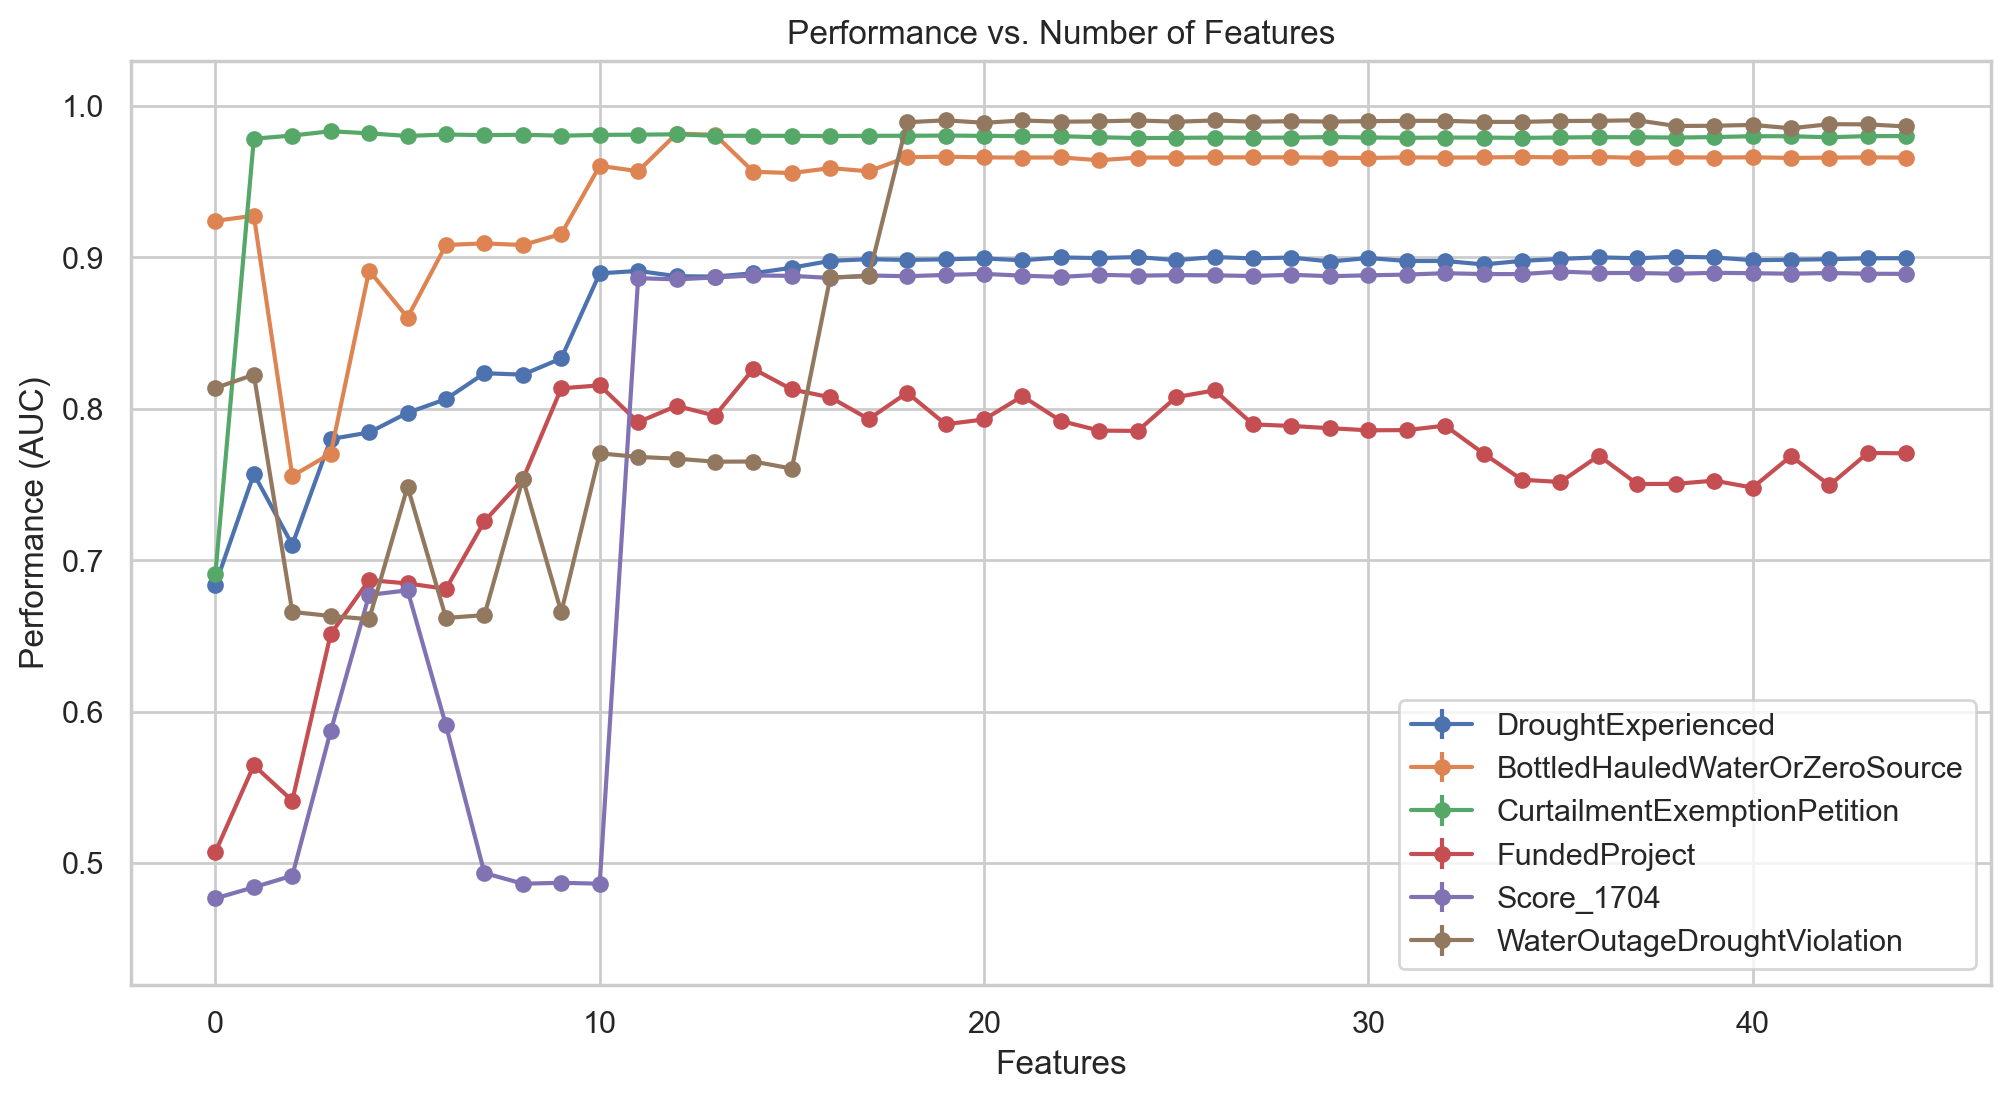

In [553]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(np.arange(len(df_auc['AUC Scores'][0])),np.flip(df_auc['AUC Scores'][0]), yerr=np.flip(df_auc['AUC Standard Deviation'][0]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][0])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][2])),np.flip(df_auc['AUC Scores'][2]), yerr=np.flip(df_auc['AUC Standard Deviation'][2]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][2])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][3])),np.flip(df_auc['AUC Scores'][3]), yerr=np.flip(df_auc['AUC Standard Deviation'][3]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][3])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][5])),np.flip(df_auc['AUC Scores'][5]), yerr=np.flip(df_auc['AUC Standard Deviation'][5]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][5])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][4])),np.flip(df_auc['AUC Scores'][4]), yerr=np.flip(df_auc['AUC Standard Deviation'][4]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][4])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][1])),np.flip(df_auc['AUC Scores'][1]), yerr=np.flip(df_auc['AUC Standard Deviation'][1]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][1])
ax.set_xlabel('Features')
ax.set_ylabel('Performance (AUC)')
ax.set_title('Performance vs. Number of Features')
ax.set_ylim([0.42, 1.03])
ax.legend()
fig.savefig('performancevsfeaturesvslabel_nogw.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 7: Where are these drought-impacted CWS?

In [82]:
drought_df = df[df['DroughtExperienced'] == 1]
safe_df = df[df['DroughtExperienced'] == 0]

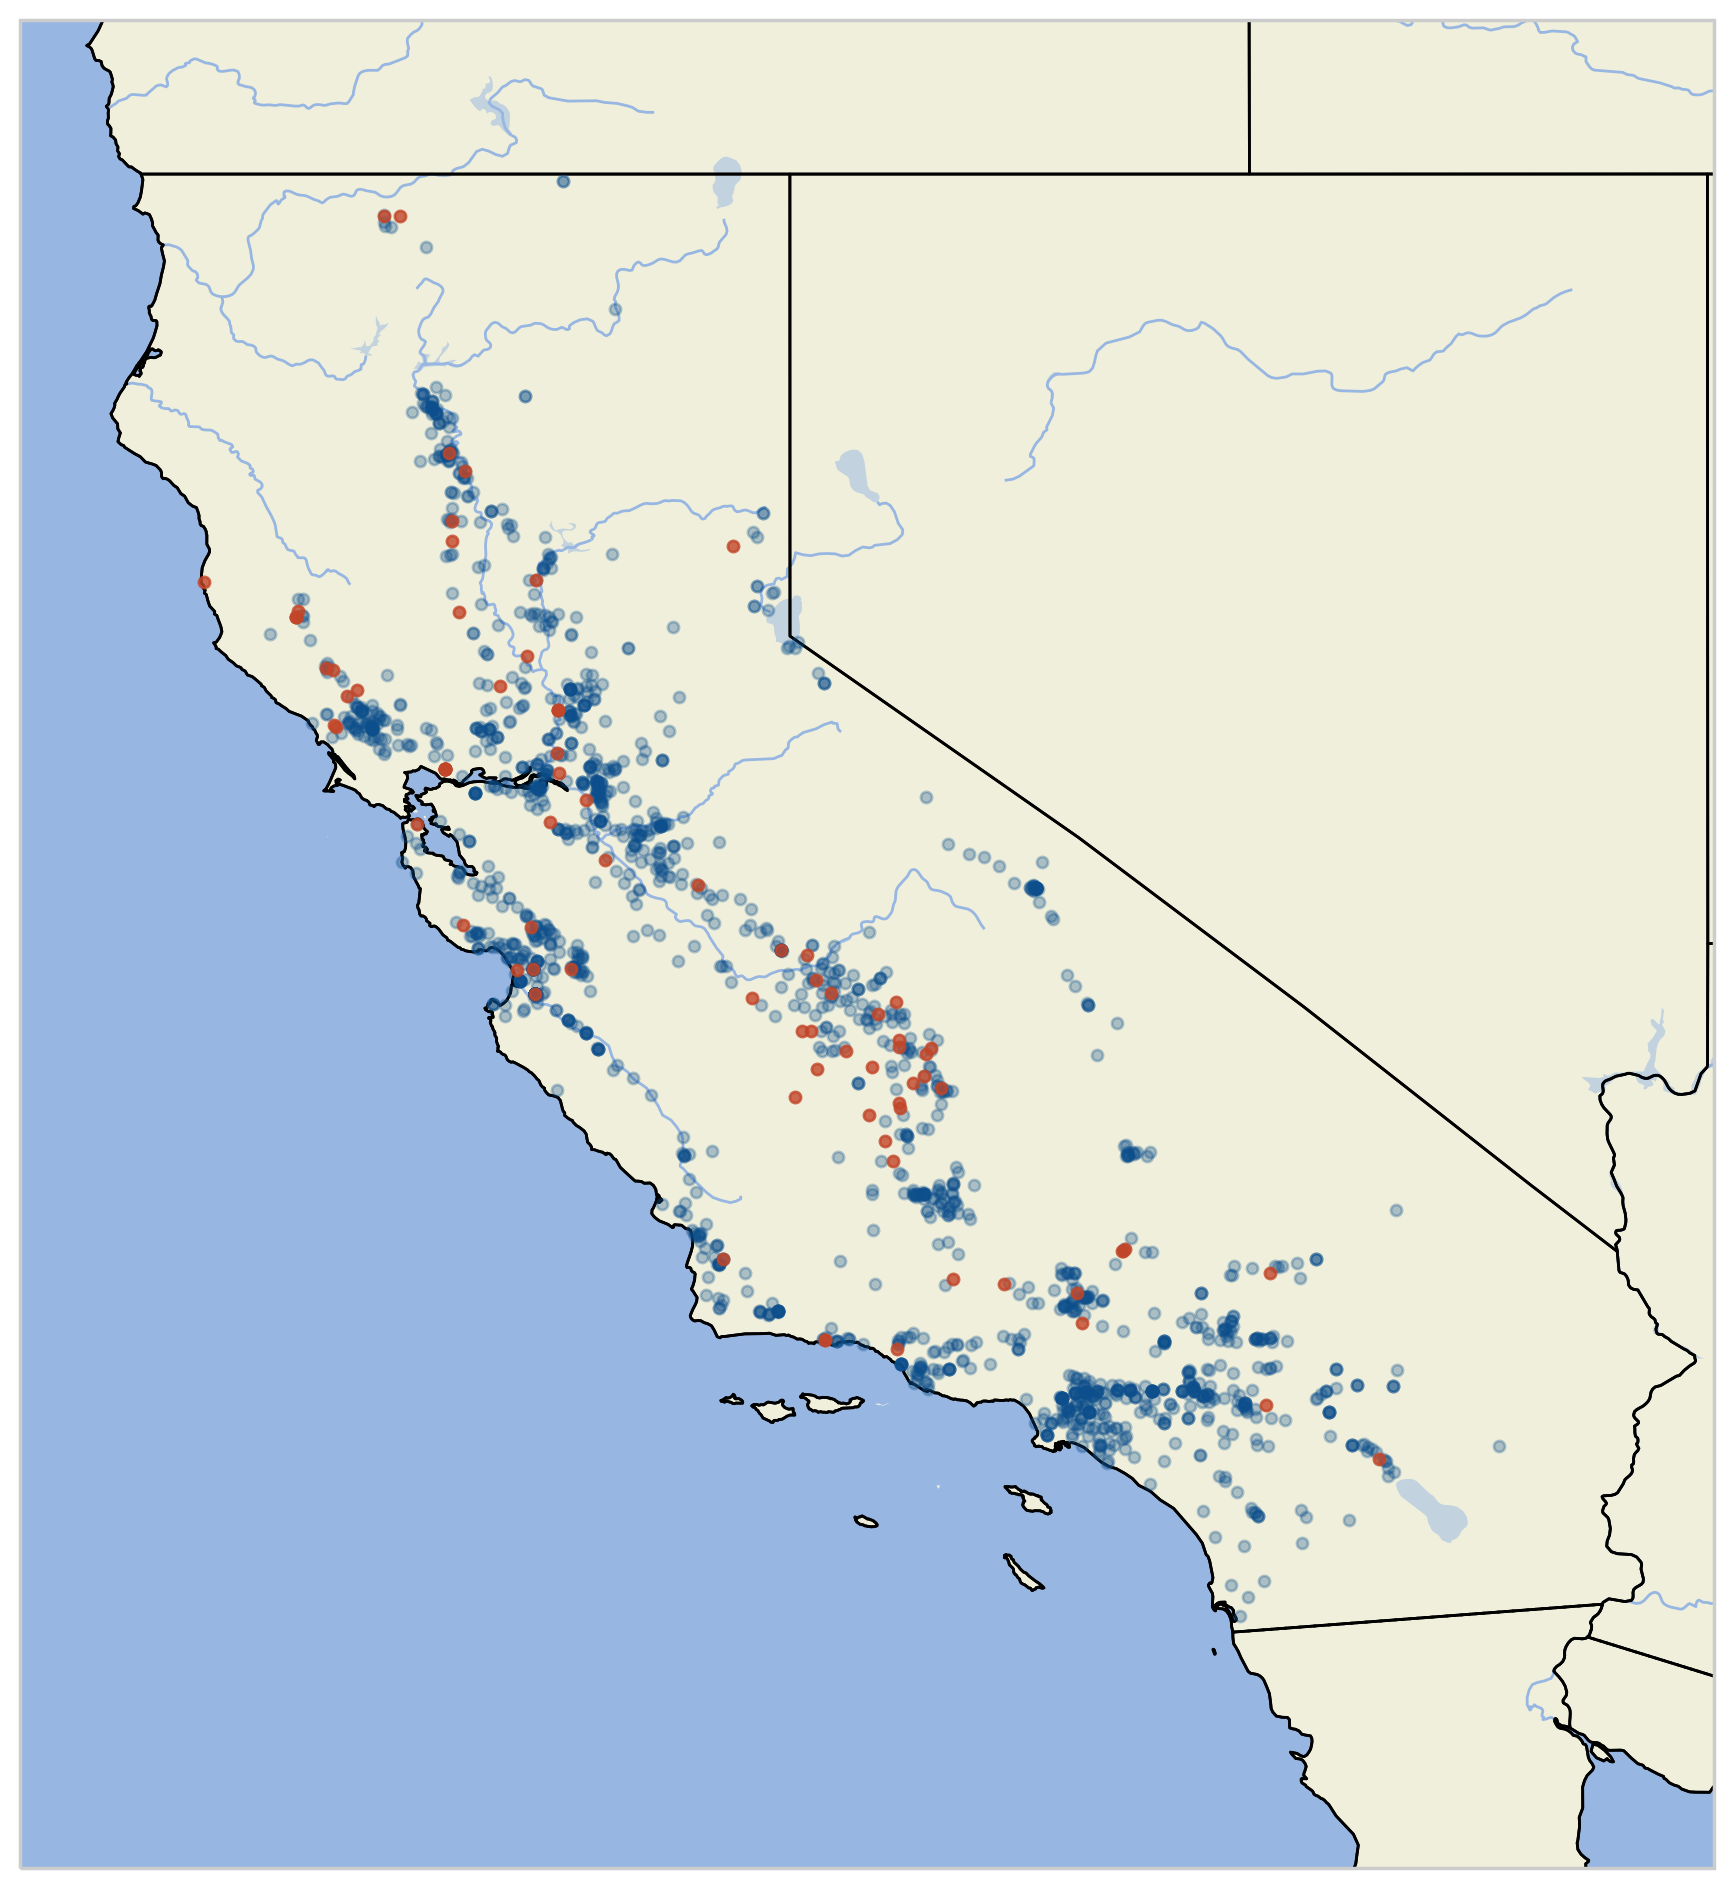

In [83]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-125, -114, 31, 43], crs=ccrs.PlateCarree())

odi_blue = "#0D4F8C"
odi_red = "#C24629"

ax.plot(safe_df['PWPhysicalAddressLong'],safe_df['PWPhysicalAddressLat'], marker='o', 
        linestyle='None', color=odi_blue, markersize=4, alpha=0.3, transform=ccrs.PlateCarree())
ax.plot(drought_df['PWPhysicalAddressLong'],drought_df['PWPhysicalAddressLat'], marker='o', 
        linestyle='None', color=odi_red, markersize=4, alpha=0.8, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES)

plt.show()

#fig.savefig('locations.png', dpi=300, transparent=True, bbox_inches='tight')